In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import chaospy
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

# Sampling a 32-d banana

In [2]:
from scipy.stats import special_ortho_group

n = 32 # number of dims
Q = 0.1
lower = np.full(n, -15.) # lower bound of the prior
upper = np.full(n, 15.) # upper bound of the prior

bounds = np.array([lower, upper])

# Not doing this for now ...
np.random.seed(0)
A = special_ortho_group.rvs(n) # random rotation of the bananas

def log_like(x):
    #x = jnp.matmul(x, jnp.transpose(A))
    return -jnp.sum((x[..., ::2]**2 - x[..., 1::2])**2 / Q + 
                    (x[..., ::2] - 1)**2, axis=-1)

def log_flat_prior(x, lower=lower, upper=upper):
    return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc=lower, scale=upper-lower))

jax_prior_init = jax.random.uniform(key, shape=(1000, n), minval=lower, maxval=upper)

log_like_grad = jax.grad(log_like)
log_prior_grad = jax.grad(log_flat_prior)

Below I have defined the key parameters that I think you will need to worry about. If you look at the actual code you'll see a lot more parameters. Some of these are from older versions of the algorithm, and some of these are only relevant for the NFO optimization algorithm. We'll tidy this up at some point, but this should be enough to get you going.

In [15]:
'''
General parameters
------------------
In addition to the log-likelihood and prior functions defined above that you'll pass, we have:

1. log_like_args: Any additional arguments to be passed to the log-likelihood function as a tuple object.
2. log_prior_args: As above but for the prior. Not necessary here, but I've included arguments for illustration.
3. inference_mode: Either 'optimization' or 'sampling'. You'll want 'sampling'.
4. vmap: If True we evaluate the log-likelihood and prior functions using a vectorizing map (i.e. jax.vmap). 
   If False we parallelise the computation over available cores. The parallelisation has been tested on NERSC, 
   but I've pretty much exclusively been using vmap (you may want to parallelise if you have some very expensive 
   likelihoods).
5. parallel_backend: If using parallel evaluations, choose the parallel backend. Can be set to Pool, Client or
   MapReduce. Will use multiprocess, dask or sharedmem respectively. If left as None, will use multiprocess.
6. bounds: Any hard parameter bounds to pass to SINF/SNF. Passed as array([lower_bounds, upper_bounds]). None
   if no hard bounds.
7. k_trunc: Clipping parameter for importance weights. IW clipped at <IW>*N^k_trunc. Note, not currently used
   with SMC-type sampling.
8. random_seed: Random seed for inference.
'''
log_like_args = ()
log_prior_args = () 
inference_mode = 'DLA'
vmap = True
parallel_backend = None
bounds = np.array([lower, upper])
k_trunc = 0.5
random_seed = seed

'''
SINF/SNF parameters
---------------
Key SINF/SNF parameters. See GIS.py, SINF.py and optimize.py for code.

1. alpha_w: Regularisation parameters for weighted q SINF fits. Passed as a tuple of two values between 0 and 1. 
   Closer to 1 will give more regularisation. If set to None, SINF uses cross-validation to choose a value.
2. NBfirstlayer: Whether to use a Naive Bayes first layer in SINF.
3. verbose: Whether you want verbose output from SINF.
4. interp_nbin: Number of spline knots for rational quadratic splines in SINF. 
5. trainable_qw: Whether to run SNF after SINF. This was relevant when SINF and SNF were contained in the same
   method. There are separate methods now, and I'm using this so I can more easily change things. You should
   probably leave this as False for now. It won't break anything if you set it as True. Just means you'll run 
   SNF one more time than you think.
6. sgd_steps: Number of stochastic gradient descent steps to take for SNF training.
7. gamma: Parameter in loss function 1 (log E(q^(-gamma)*(p - Zq)^2)). 
8. knots_trainable: Only relevant if trainable_qw is True, in which case this overwrites interp_nbin.
9. optimize_directions: Whether we optimize directions in SNF.
10. logp_cut: logp threshold to be applied during SNF training. Currently I don't impose a cut.
11. edge_bins: Number of spline knots at the boundary.
12. Whiten: Whether to include a whitening layer for SINF.
13. iteration: Maximum number of SINF layers.
'''
#sinf parameters
alpha_w = (0.0, 0.9)
NBfirstlayer = True
verbose = False
interp_nbin = 5
trainable_qw = False # Just leave this for now.
sgd_steps = 10
gamma = 0
knots_trainable = 5
optimize_directions = False
logp_cut = None
edge_bins = 0
Whiten = True
Whiten_with_weights = True
iteration = None
NERCOME = False
frac_validate = 0.1
t_ess = 0.2

'''
SMC parameters
--------------
Parameters used for SMC and MH exploration strategies.

1. nfmc_frac_validate: Fraction of samples used in validation for SINF/SNF.
2. min_delta_beta_init: Minimum relative change in beta at start.
3. min_delta_beta_final: Minimum relative change in beta at end. delta_beta decays to this between start and end.
4. snf_loss: Specify the SNF loss function. (0) E(q^(-gamma)*(p - Zq)^2), (1) log E(q^(-gamma)*(p - Zq)^2),
   (2) sum((logp-logq-logZ)^2), (3) -E(logq), (4) log(E((q/q_uw)(p/q - Z)^2)).
5. nfmc_snf_only: Whether to only use trainable SNF updates to q after the first q fit.
6. fixed_beta_schedule: Can specify a fixed beta schedule as a list of beta values.
7. vanilla_smc: Whether to use the SMC+MH exploration strategy. This is currently the focus for sampling.
   Old option was to intialise using NFO optimization.
8. reg: SNF regularisation parameter.
9. reg1: SNF regularisation parameter.
10. mh_mode: Specify 'IMH' for independent MH exploration, 'CMH' for latent space MH, 'both' for using both.
    CMH is still being tested so stick with 'IMH' for now.
11. imh_target_acc_rate: Target acceptance fraction for original samples in IMH.
12. max_imh_steps: Maximum number of IMH iterations at a given temperature level.
13. cmh_target_acc_rate: Target acceptance rate for CMH exploration.
14. max_cmh_steps: Maximum number of steps in a CMH chain.
15. cmh_p_acc_rate: Parameter used for tuning number of CMH steps. Between 0 and 1. Closer to 1 results in more
    steps.
'''
nfmc_frac_validate = 0.1
min_delta_beta_init = 0.01
min_delta_beta_final = 0.01
snf_loss = 3
nfmc_snf_only = False
fixed_beta_schedule = None
vanilla_smc = True
reg = 0.0
reg1 = 1.0
reg2 = 1.0
latent_mcmc = 'Slice'
slice_iterations = 10
imh_target_acc_rate = 0.5
max_imh_steps = 25
cmh_target_acc_rate = 0.234
max_cmh_steps = 25
cmh_p_acc_rate = 0.85

'''
DLA parameters
--------------
1. dla_step_size: Initial DLA step size, from which we conduct a line search until p increases.
2. num_extra_dla_samples: Number of additional samples to add after running DLA until gradient norms are comparable.
3. grad_norm_thresh: Threshold at which we declare the gradient norms to be comparable.
'''
dla_step_size = 1.0
num_extra_dla_samples = 0
grad_norm_thresh = 0.1
max_dla_line_steps = 20
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
eps_z = 0.1
accelerate_dla = True
grad_free_dla = False
dla_beta_thresh = 1.0
latent_dla = False
rel_fish_tol = 1e-4
abs_fish_tol = 1e-3
max_dla_iter = 40

Now we can run our 10d Gaussian example.

In [16]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_flat_prior, 
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args, 
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             frac_validate=frac_validate,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             NERCOME=NERCOME,
                             slice_iterations=slice_iterations,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             eps_z=eps_z,
                             accelerate_dla=accelerate_dla,
                             grad_free_dla=grad_free_dla, 
                             dla_beta_thresh=dla_beta_thresh,
                             t_ess=t_ess,
                             latent_dla=latent_dla,
                             rel_fish_tol=rel_fish_tol,
                             abs_fish_tol=abs_fish_tol,
                             max_dla_iter=max_dla_iter)

Inference mode is DLA. Maximum beta is set to 1.
Current logZ estimate = -287332.5625
DLA acceleration beta = 2.86102294921875e-06
Number of DLA line seach iterations: 20
Acceptance rate for MH adjustment: 0.046
Current logZ estimate = -8292.6533203125
Burnin Stage 1, Fisher Divergence: 4771649536.0
Burnin stage 1, abs(norm(dlogq)/norm(dlogp)) = 0.00031960010528564453
DLA acceleration beta = 6.008148193359375e-05
Number of DLA line seach iterations: 11
Acceptance rate for MH adjustment: 0.238
Current logZ estimate = -5574.1416015625
Burnin Stage 2, Fisher Divergence: 78250360.0
Burnin stage 2, abs(norm(dlogq)/norm(dlogp)) = 0.0013185619609430432
DLA acceleration beta = 0.00022029876708984375
Number of DLA line seach iterations: 15
Acceptance rate for MH adjustment: 0.34
Current logZ estimate = -5184.09912109375
Burnin Stage 3, Fisher Divergence: 24263262.0
Burnin stage 3, abs(norm(dlogq)/norm(dlogp)) = 0.001986162969842553
DLA acceleration beta = 0.000392913818359375
Number of DLA line

DLA acceleration beta = 0.003936767578125
Number of DLA line seach iterations: 1
Acceptance rate for MH adjustment: 0.002
Current logZ estimate = -295.0669860839844
Burnin Stage 30, Fisher Divergence: 303395.5
Burnin stage 30, abs(norm(dlogq)/norm(dlogp)) = 0.0080509502440691
DLA acceleration beta = 0.004058837890625
Number of DLA line seach iterations: 1
Acceptance rate for MH adjustment: 0.004
Current logZ estimate = -275.1119384765625
Burnin Stage 31, Fisher Divergence: 285435.65625
Burnin stage 31, abs(norm(dlogq)/norm(dlogp)) = 0.008368941955268383
DLA acceleration beta = 0.00417327880859375
Number of DLA line seach iterations: 1
Acceptance rate for MH adjustment: 0.002
Current logZ estimate = -257.2654724121094
Burnin Stage 32, Fisher Divergence: 268789.75
Burnin stage 32, abs(norm(dlogq)/norm(dlogp)) = 0.008967077359557152
DLA acceleration beta = 0.004302978515625
Number of DLA line seach iterations: 1
Acceptance rate for MH adjustment: 0.003
Current logZ estimate = -244.3701477

Number of DLA line seach iterations: 21
Acceptance rate for MH adjustment: 0.0
Current logZ estimate = 51.71625900268555
DLA Stage 16, Fisher Divergence: 68863.203125
DLA acceleration beta = 0.007720947265625
Number of DLA line seach iterations: 21
Acceptance rate for MH adjustment: 0.0
Current logZ estimate = 48.18437957763672
DLA Stage 17, Fisher Divergence: 66329.4296875
DLA acceleration beta = 0.0079193115234375
Number of DLA line seach iterations: 21
Acceptance rate for MH adjustment: 0.0
Current logZ estimate = 52.815513610839844
DLA Stage 18, Fisher Divergence: 63899.05078125
DLA acceleration beta = 0.00798797607421875
Number of DLA line seach iterations: 21
Acceptance rate for MH adjustment: 0.0
Current logZ estimate = 48.56839370727539
DLA Stage 19, Fisher Divergence: 61589.32421875
DLA acceleration beta = 0.0081939697265625
Number of DLA line seach iterations: 21
Acceptance rate for MH adjustment: 0.0
Current logZ estimate = 51.39519119262695
DLA Stage 20, Fisher Divergence: 

The output from sampling is stored in the trace object. This is currently a collection of dictionaries containing a lot of output stats and samples for development/debugging purposes.

In [5]:
# Check the dictionary keys.
trace.keys()

dict_keys(['final_q_samples', 'final_qw_weights', 'log_evidence', 'mh_samples', 'dla_samples', 'mh_logp', 'mh_logq', 'mh_dlogp', 'mh_dlogq', 'dla_logZ', 'dla_qmodels'])

In [6]:


def plot_triangles(samples, weights, Cov, Ngd=1000, beta_idx=None,
                   out_name=None):

    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]
    
    truth = n_mvn.rvs(mean=np.zeros(n), cov=Cov, size=Ngd)
    truth_gd = MCSamples(samples=truth,names = names, labels = labels, label='truth')

    samples_w = MCSamples(samples=samples, weights=weights,
                          names=names, labels=labels, 
                          label='posterior samples')

    # Triangle plot
    plt.figure()
    g = plots.get_subplot_plotter()
    g.triangle_plot([truth_gd, samples_w], filled=True)
    plt.show()
    if out_name is not None:
        g.export(out_name)

In [7]:
# First plot the samples without weights.
q_samples = np.asarray(trace['final_q_samples'][0])
q_weights = np.asarray(trace['final_qw_weights'][0])

In [8]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

In [9]:
truth_df = pd.read_csv('./fiducial_samples/banana_32d_invQ100.csv', index_col=0)
truth_x = np.empty((4000, n))

for i in range(n):
    
    truth_x[:, i] = truth_df["('posterior', 'x[{0}]', {1})".format(i, i)]

     labels     $x_0$     $x_1$     $x_2$      $x_3$
0         q  1.211704 -3.669712 -0.357207  -3.931406
1         q  0.163170 -0.702600  3.369953  11.225378
2         q -1.111648  4.186262  0.661926   5.510193
3         q  1.527039  0.404134  0.991625   0.211737
4         q  0.170823  1.063038 -0.364671  14.216566
...     ...       ...       ...       ...        ...
5995      T -0.251747 -0.042651  1.518607   2.256535
5996      T  1.373019  1.808306  0.026317  -0.007030
5997      T  1.774758  3.002452 -0.058184   0.003645
5998      T  0.291324  0.042222  2.014724   4.011918
5999      T  0.709743  0.551182  2.034010   3.949526

[6000 rows x 5 columns]


ValueError: array length 5000 does not match index length 6000

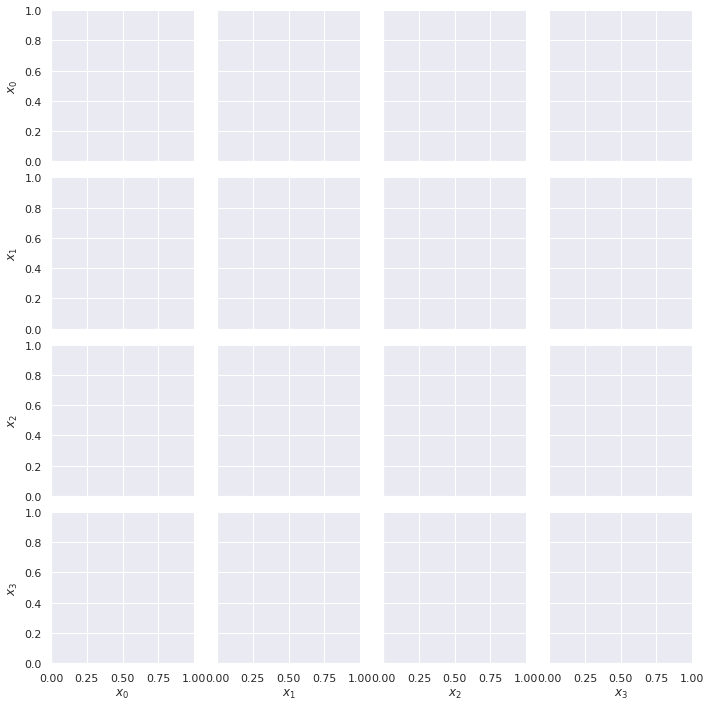

In [14]:

sns_pairplot(q_samples[:, 0:4], q_weights, truth_x[:, 0:4], levels=4, 
             out_name='./dla_figs/banana_32d_30layers_final_q_weighted.png')

     labels     $x_0$     $x_1$     $x_2$      $x_3$
0         q -1.494121  4.048210 -1.186239   4.145115
1         q -2.939577  0.972748  0.704194  14.403713
2         q  0.413180 -0.733301  1.548698  -0.246119
3         q -0.717559 -2.787401  1.807343   7.193108
4         q  0.799953 -0.294704  2.481592  13.670874
...     ...       ...       ...       ...        ...
4995      T -0.251747 -0.042651  1.518607   2.256535
4996      T  1.373019  1.808306  0.026317  -0.007030
4997      T  1.774758  3.002452 -0.058184   0.003645
4998      T  0.291324  0.042222  2.014724   4.011918
4999      T  0.709743  0.551182  2.034010   3.949526

[5000 rows x 5 columns]


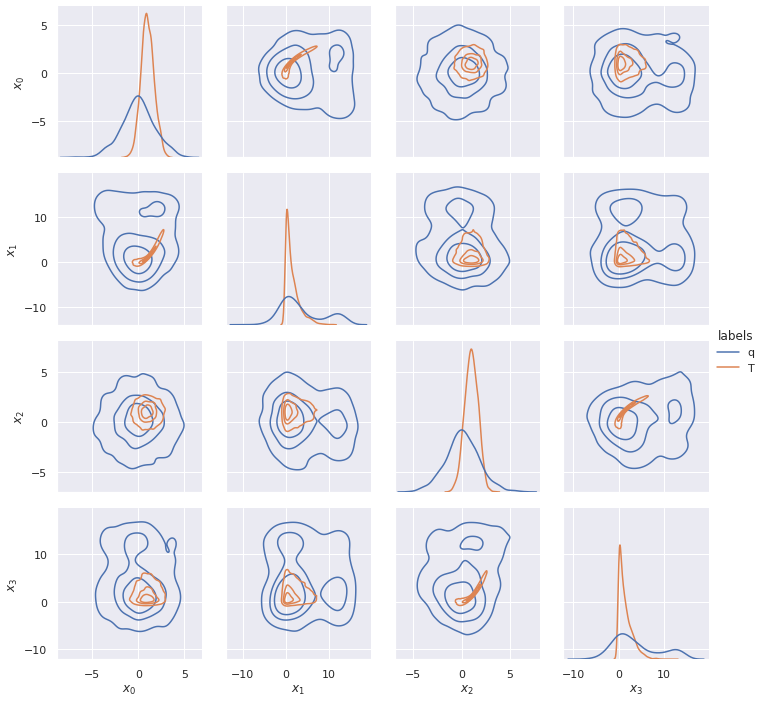

In [10]:
sns_pairplot(q_samples[:,0:4], np.ones(len(q_samples)), truth_x[:,0:4], levels=4, 
             out_name='./dla_figs/banana_32d_30layers_final_q_unweighted.png')

In [11]:
dla_samples = trace['mh_samples'][0]
dla_samples.keys()

dict_keys(['burnin_0', 'burnin_1', 'burnin_2', 'burnin_3', 'burnin_4', 'burnin_5', 'burnin_6', 'burnin_7', 'burnin_8', 'burnin_9', 'burnin_10', 'burnin_11', 'burnin_12', 'burnin_13', 'burnin_14', 'burnin_15', 'burnin_16', 'post_burnin_0', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'DLA_11', 'DLA_12', 'DLA_13', 'DLA_14', 'DLA_15', 'DLA_16', 'DLA_17', 'DLA_18', 'DLA_19', 'DLA_20', 'DLA_21', 'DLA_22', 'DLA_23', 'DLA_24', 'DLA_25', 'DLA_26', 'DLA_27', 'DLA_28', 'DLA_29', 'DLA_30', 'DLA_31', 'DLA_32', 'DLA_33', 'DLA_34', 'DLA_35', 'DLA_36', 'DLA_37', 'DLA_38', 'DLA_39', 'DLA_40', 'DLA_41'])

     labels     $x_0$      $x_1$     $x_2$      $x_3$
0         q -3.816898  14.767977 -1.030298   1.070097
1         q -0.248044   0.071390 -3.292985  10.741571
2         q -0.537908   0.317823  3.152704  10.003418
3         q -0.069660  -0.031025  0.284625   0.095621
4         q  1.339939   1.843058  1.516827   2.240622
...     ...       ...        ...       ...        ...
4995      T -0.251747  -0.042651  1.518607   2.256535
4996      T  1.373019   1.808306  0.026317  -0.007030
4997      T  1.774758   3.002452 -0.058184   0.003645
4998      T  0.291324   0.042222  2.014724   4.011918
4999      T  0.709743   0.551182  2.034010   3.949526

[5000 rows x 5 columns]


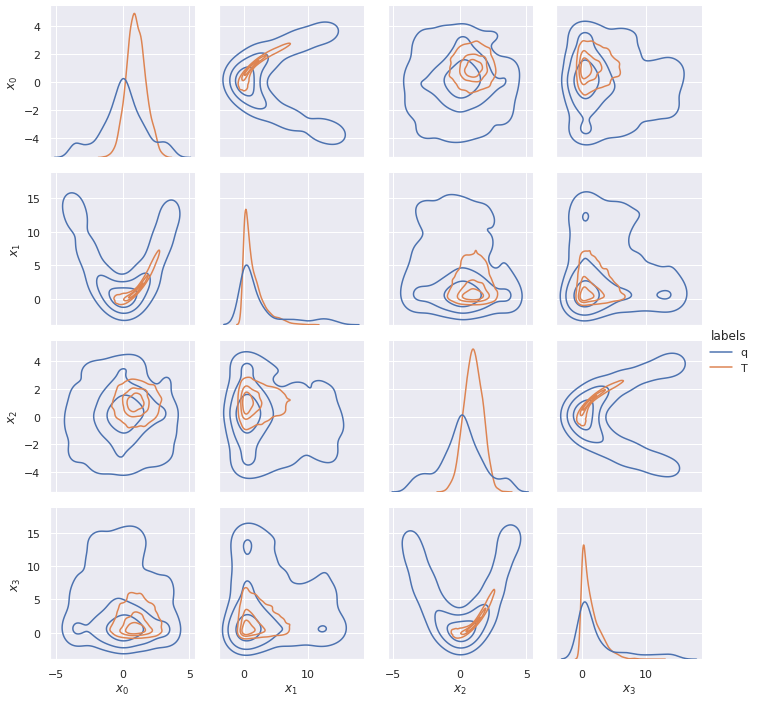

In [12]:
fkey = list(dla_samples.keys())[-10]

fkey = 'DLA_40'
sns_pairplot(dla_samples[fkey][:, 0:4], np.ones(len(dla_samples[fkey])), truth_x[:,0:4], levels=4,
             out_name='./dla_figs/banana_32d_30layers_final_dla_samples.png')

     labels     $x_0$     $x_1$     $x_2$      $x_3$
0         q  1.211704 -3.669712 -0.357207  -3.931406
1         q  0.163170 -0.702600  3.369953  11.225378
2         q -1.111648  4.186262  0.661926   5.510193
3         q  1.527039  0.404134  0.991625   0.211737
4         q  0.170823  1.063038 -0.364671  14.216566
...     ...       ...       ...       ...        ...
5995      T -0.251747 -0.042651  1.518607   2.256535
5996      T  1.373019  1.808306  0.026317  -0.007030
5997      T  1.774758  3.002452 -0.058184   0.003645
5998      T  0.291324  0.042222  2.014724   4.011918
5999      T  0.709743  0.551182  2.034010   3.949526

[6000 rows x 5 columns]


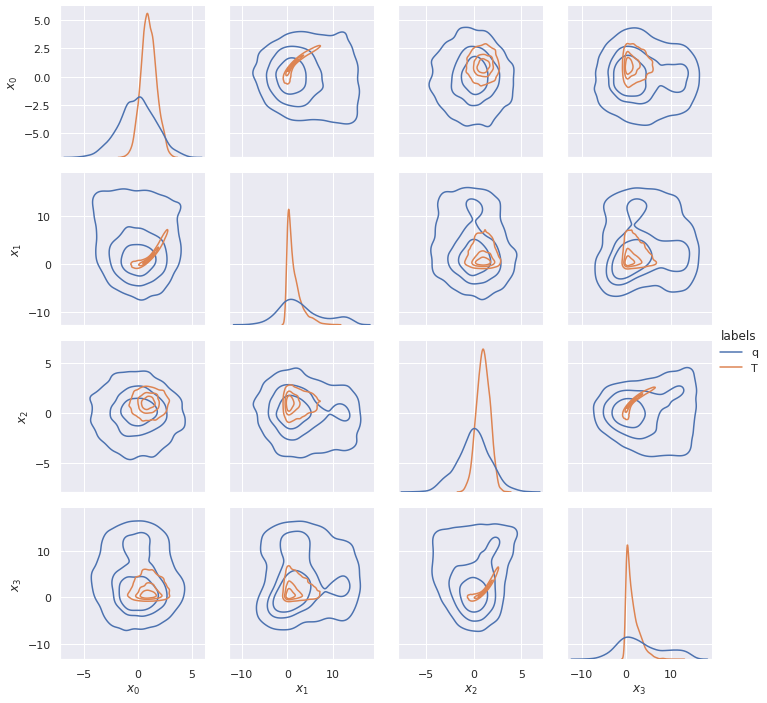

In [13]:
key = 'DLA_40'
q_models = trace['dla_qmodels'][0]

qi = q_models[key]
q_samples, logq = qi.sample(2000, device='cpu')
q_samples, logq = q_samples.numpy(), logq.numpy()
iw = jax.vmap(lambda x: log_like(x))(q_samples)
logp = jax.vmap(lambda x: log_like(x))(q_samples)
logw = logp - logq
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)
    
sns_pairplot(q_samples[:, 0:4], np.ones(len(q_samples)), truth_x[:, 0:4], levels=4)

In [ ]:
beta = 1

x_prime = np.random.normal(0, 1, size=(2000, D))
x_prime[:, 0] = x_prime[:, 0] * a / np.sqrt(beta)
x_prime[:, 1:] = x_prime[:, 1:] * np.exp(b * x_prime[:, 0]).reshape((2000, 1)) / np.sqrt(beta)

for key in list(q_models.keys()):

    # There were 10 temperature levels. q10_w corresponds to the q fit at beta=1 i.e. the target.
    qi = q_models[key]
    q_samples, logq = qi.sample(2000, device='cpu')
    q_samples, logq = q_samples.numpy(), logq.numpy()
    iw = jax.vmap(lambda x: log_like(x))(q_samples)
    logp = jax.vmap(lambda x: log_like(x))(q_samples)
    logw = logp - logq
    logw -= logsumexp(logw)
    iw = np.exp(logw)
    iw /= np.sum(iw)
    
    sns_pairplot(q_samples[:, 0:4], iw, x_prime[:, 0:4], levels=4, 
                 out_name=f'./dla_figs/funnel_16d_{key}_20layers.png')

# Nice plots for visualizing the DLA updates ...

In [48]:
dla_samples = trace['dla_samples'][0]
mh_samples = trace['mh_samples'][0]

In [49]:
def quiver_plot(init_samples, dla_updates, mh_updates, truth=None, q_samples=None, levels=4, out_name=None,
                figsize=(2 * 8.09, 2 * 5.0), markersize=10):
    
    dla_diff = dla_updates - init_samples

    mh_changed = np.where(dla_updates != mh_updates)[0]
    mh_updates = mh_updates[mh_changed]
    mh_diff = mh_updates - dla_updates[mh_changed]
    
    plt.figure(figsize=figsize)
    sns.set_theme()
    sns.scatterplot(init_samples[:, 0], init_samples[:, 1], label='Initial Positions', color='#332288',
                    marker="o", s=markersize)
    sns.scatterplot(dla_updates[:, 0], dla_updates[:, 1], label='DLA updates', color='#117733',
                    marker="v", s=markersize)
    sns.scatterplot(mh_updates[:, 0], mh_updates[:, 1], label='MH updates', color='#999933',
                    marker="D", s=markersize)
    plt.quiver(init_samples[:, 0], init_samples[:, 1], dla_diff[:, 0], dla_diff[:, 1], angles='xy',
               alpha=0.5, scale_units='xy', scale=1, color='#88CCEE', label='DLA vector')
    plt.quiver(dla_updates[:, 0][mh_changed], dla_updates[:, 1][mh_changed], mh_diff[:, 0], 
               mh_diff[:, 1], angles='xy', alpha=0.5, scale_units='xy', scale=1, color='#44AA99', 
               label='MH vector')
    if truth is not None:
        sns.kdeplot(truth[:, 0], truth[:, 1], label='Target', alpha=0.5, color='#DDCC77', levels=levels)
    if q_samples is not None:
        sns.kdeplot(q_samples[:, 0], q_samples[:, 1], label='q', alpha=0.5, color='#AA4499', levels=levels)
    plt.legend(loc=2, bbox_to_anchor=(1, 1))
    if out_name is not None:
        plt.savefig(out_name, bbox_inches='tight')

/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

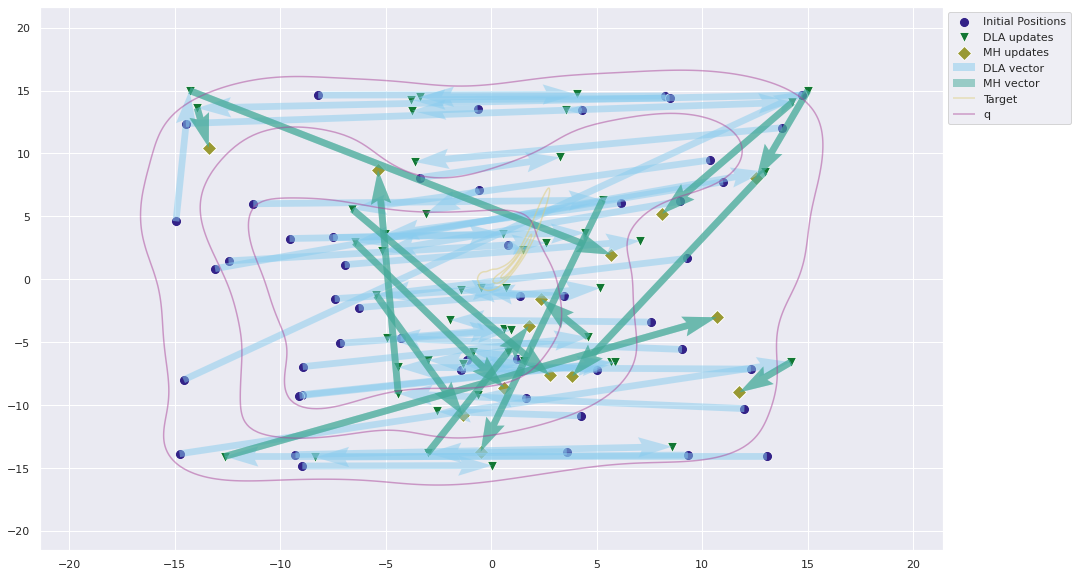

In [50]:
q = trace['dla_qmodels'][0]['burnin_0']
qx, _ = q.sample(2000, device='cpu')
qx = qx.numpy()

quiver_plot(jax_prior_init, dla_samples['burnin_0'], mh_samples['burnin_0'], truth_x[:,0:2], qx, markersize=100)

init_key = prior
Current key = burnin_0
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_0
Current key = burnin_1
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_1
Current key = burnin_2
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_2
Current key = burnin_3
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_3
Current key = burnin_4
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_4
Current key = burnin_5
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_5
Current key = burnin_6
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_6
Current key = burnin_7
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_7
Current key = burnin_8
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_8
Current key = burnin_9
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_9
Current key = burnin_10
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_10
Current key = burnin_11
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_11
Current key = burnin_12
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_12
Current key = burnin_13
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_13
Current key = burnin_14
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_14
Current key = burnin_15
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_15
Current key = burnin_16
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_16
Current key = burnin_17
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_17
Current key = burnin_18
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_18
Current key = burnin_19
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_19
Current key = burnin_20
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


<ipython-input-49-25f651bbdca4>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

init_key = burnin_20
Current key = burnin_21
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_21
Current key = burnin_22
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_22
Current key = burnin_23
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_23
Current key = burnin_24
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_24
Current key = burnin_25
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_25
Current key = burnin_26
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_26
Current key = burnin_27
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_27
Current key = burnin_28
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_28
Current key = burnin_29
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_29
Current key = burnin_30
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_30
Current key = burnin_31
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_31
Current key = burnin_32
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_32
Current key = burnin_33
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_33
Current key = burnin_34
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_34
Current key = burnin_35
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_35
Current key = burnin_36
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_36
Current key = burnin_37
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_37
Current key = burnin_38
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_38
Current key = burnin_39
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_39
Current key = burnin_40
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_40
Current key = burnin_41
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_41
Current key = burnin_42
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_42
Current key = burnin_43
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_43
Current key = burnin_44
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_44
Current key = burnin_45
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_45
Current key = burnin_46
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_46
Current key = burnin_47
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_47
Current key = burnin_48
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_48
Current key = burnin_49
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_49
Current key = burnin_50
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_50
Current key = burnin_51
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_51
Current key = burnin_52
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_52
Current key = burnin_53
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_53
Current key = burnin_54
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_54
Current key = burnin_55
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_55
Current key = burnin_56
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_56
Current key = burnin_57
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_57
Current key = burnin_58
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_58
Current key = burnin_59
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_59
Current key = burnin_60
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_60
Current key = burnin_61
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_61
Current key = burnin_62
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_62
Current key = burnin_63
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_63
Current key = burnin_64
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_64
Current key = burnin_65
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_65
Current key = burnin_66
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_66
Current key = burnin_67
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_67
Current key = burnin_68
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_68
Current key = burnin_69
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_69
Current key = burnin_70
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_70
Current key = burnin_71
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_71
Current key = burnin_72
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_72
Current key = burnin_73
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_73
Current key = burnin_74
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_74
Current key = burnin_75
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_75
Current key = burnin_76
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_76
Current key = burnin_77
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_77
Current key = burnin_78
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = post_burnin_0
Current key = DLA_1
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = DLA_1
Current key = DLA_2
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = DLA_2
Current key = DLA_3
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

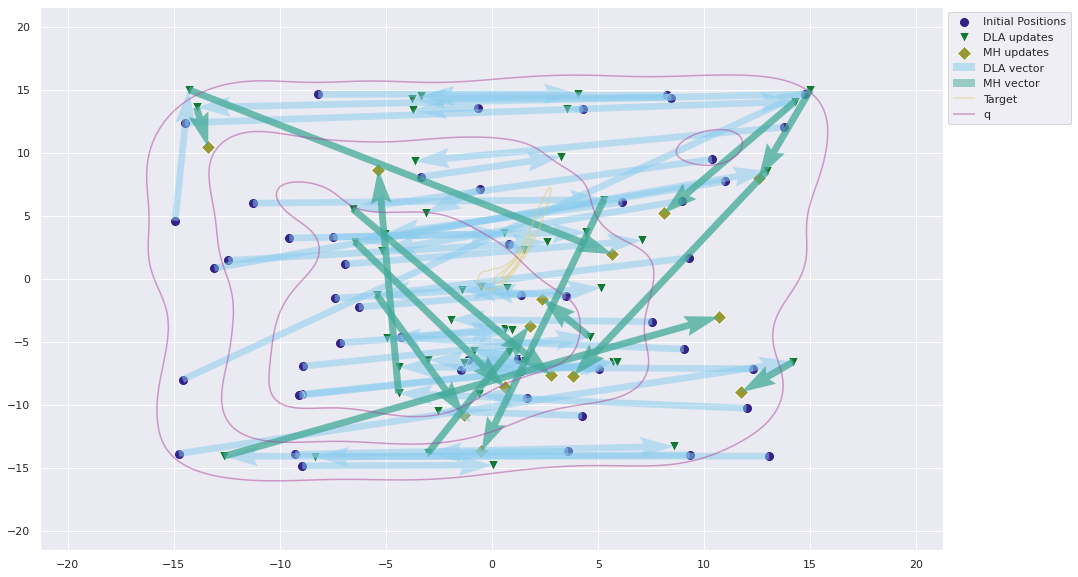

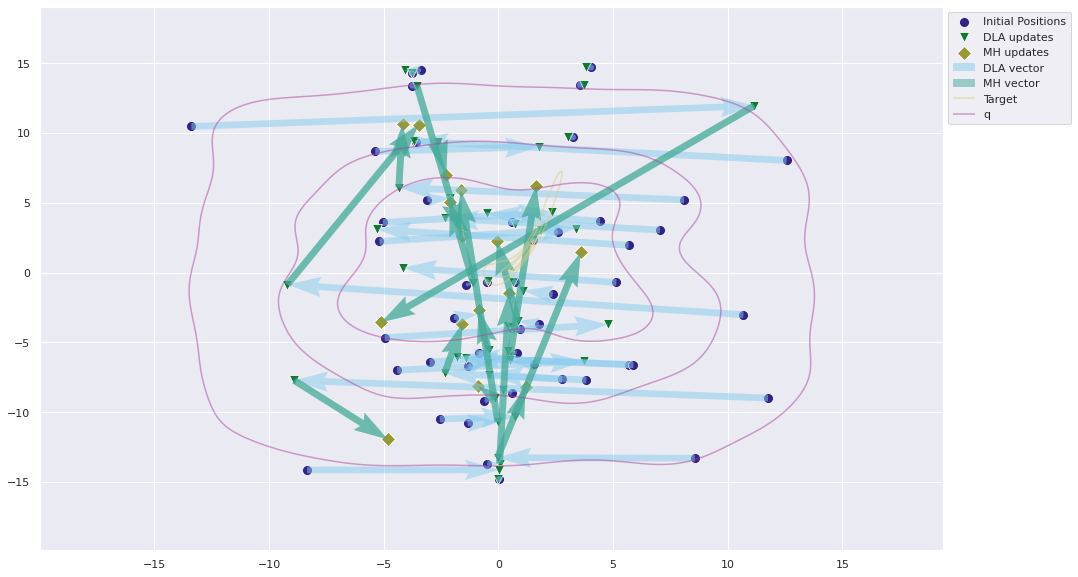

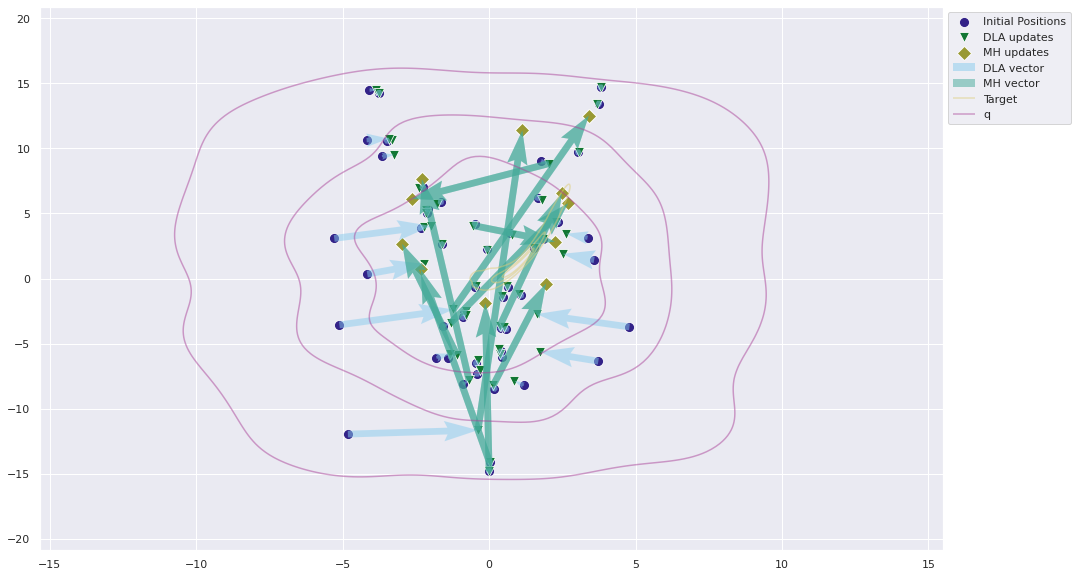

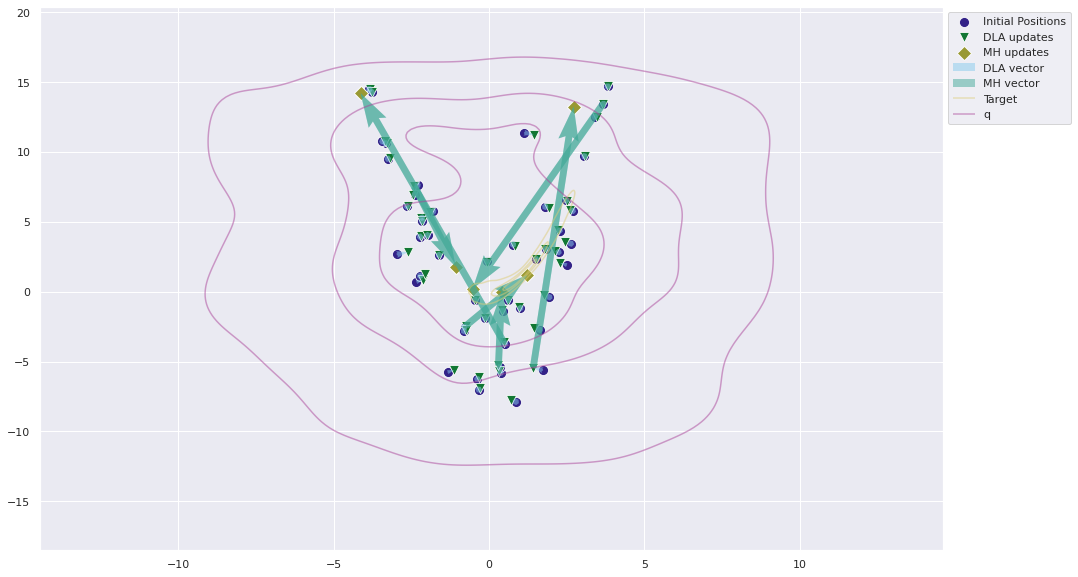

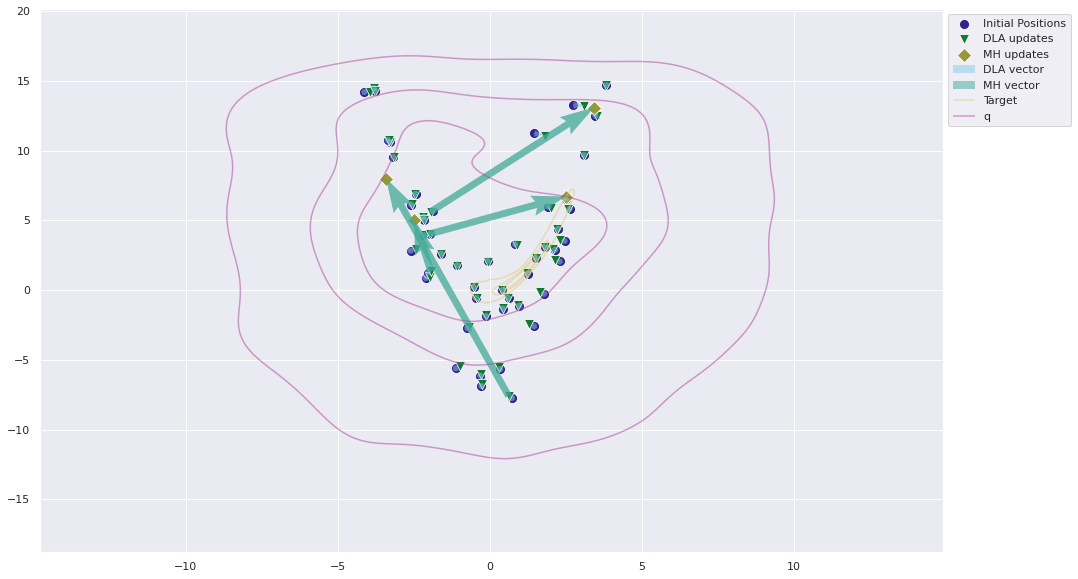

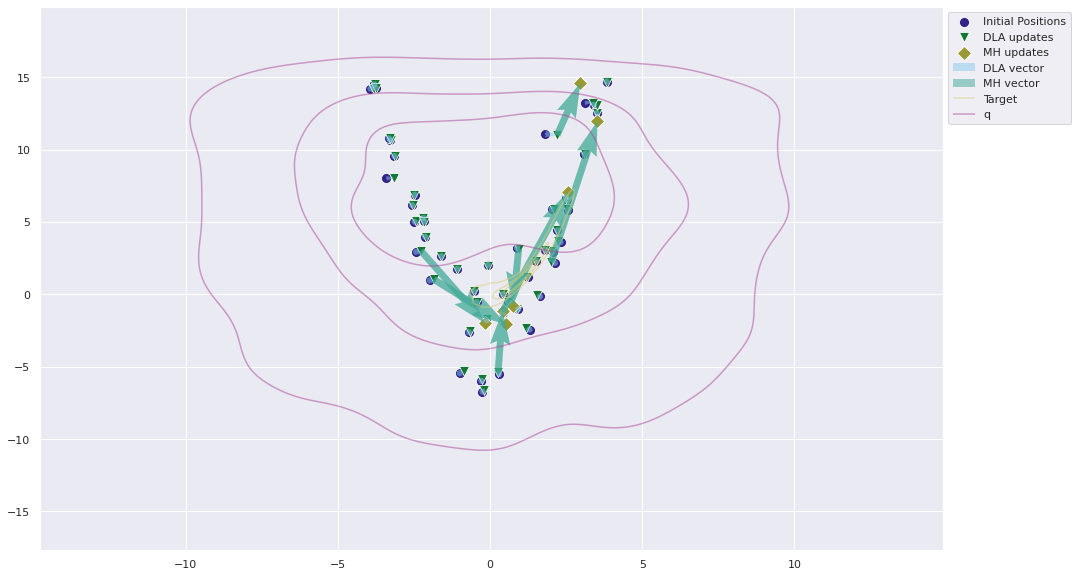

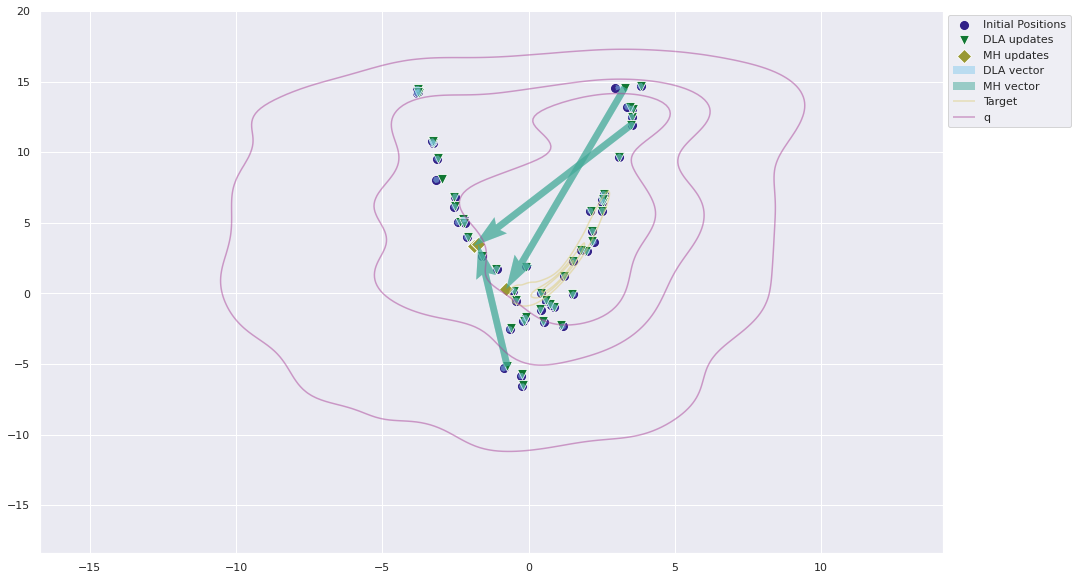

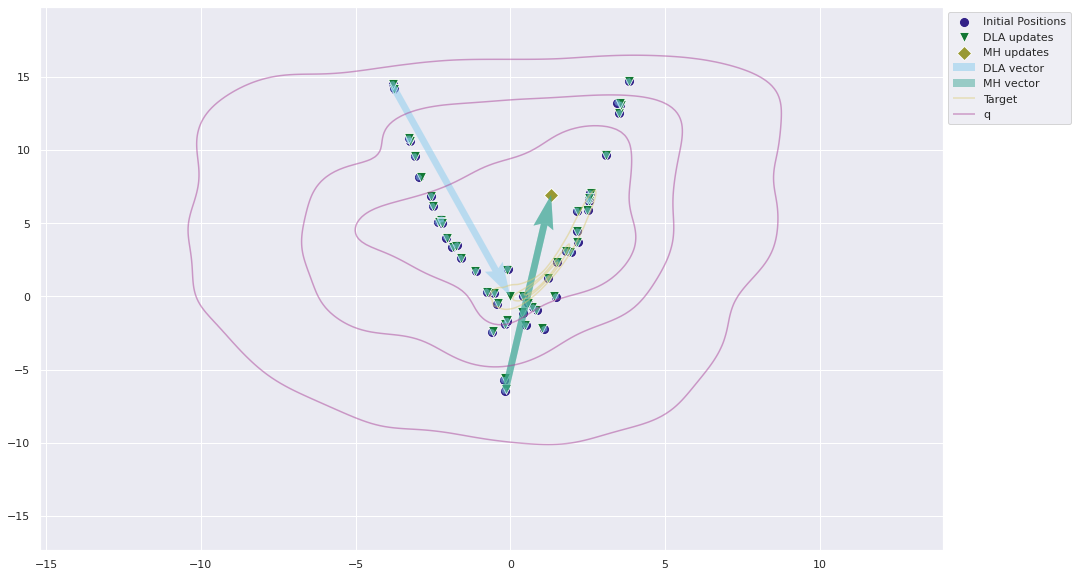

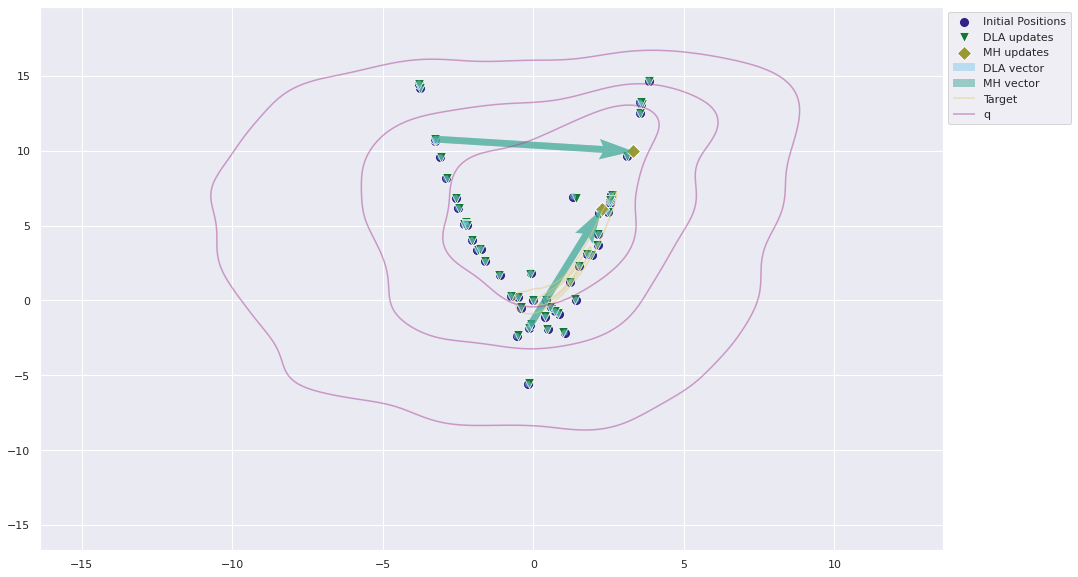

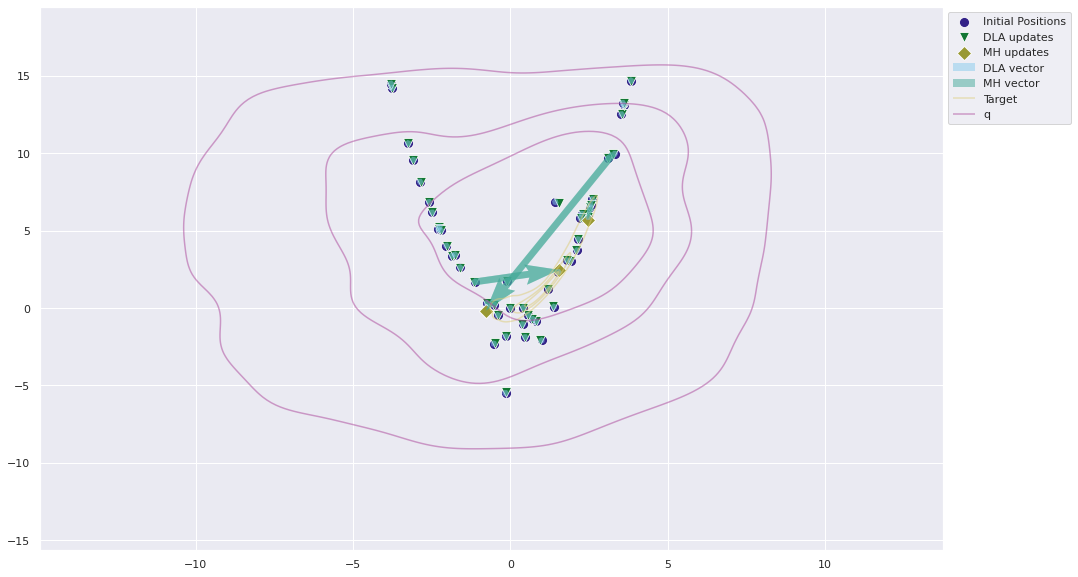

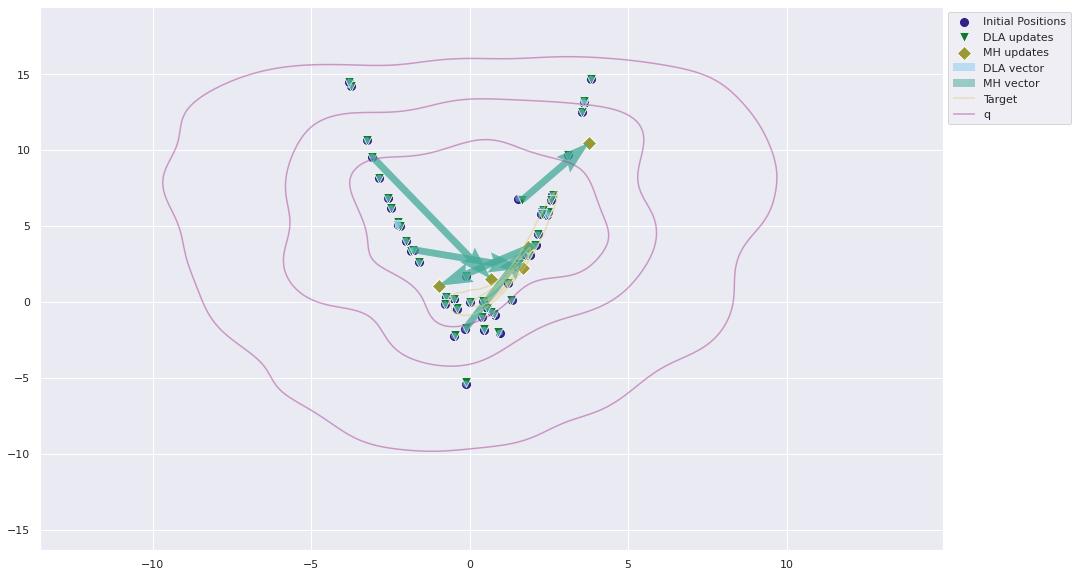

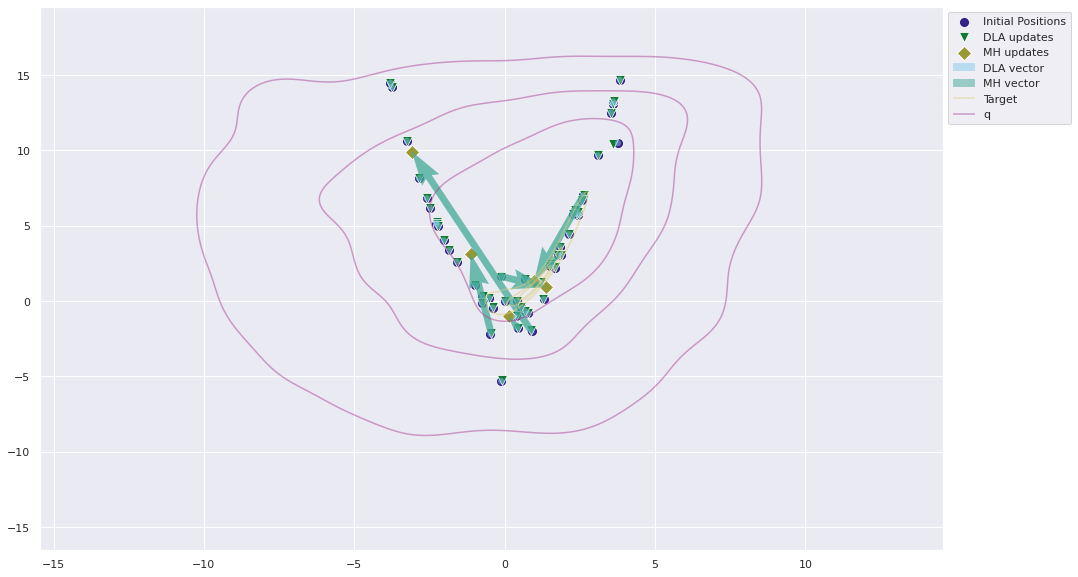

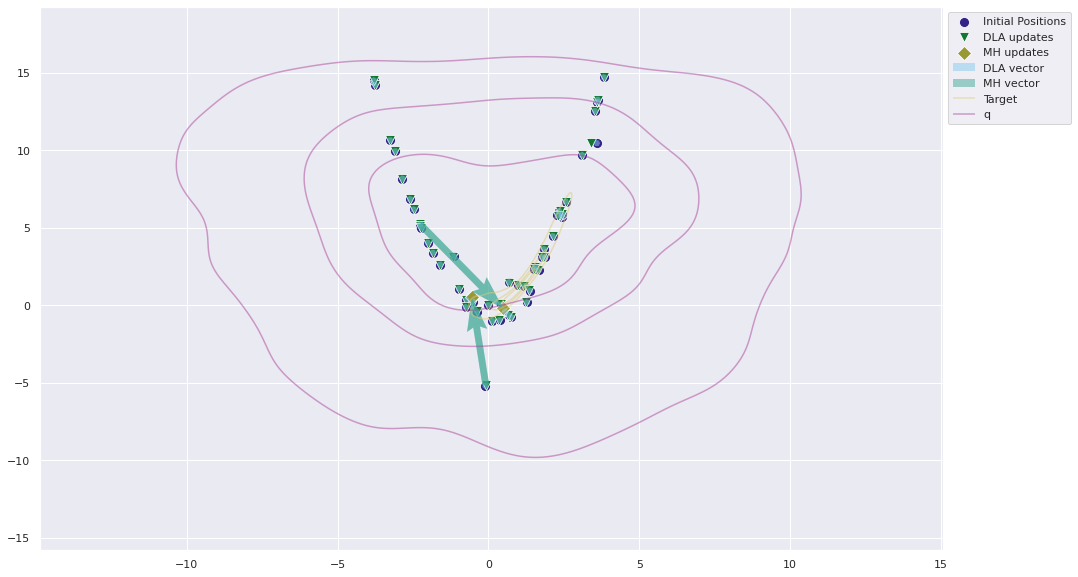

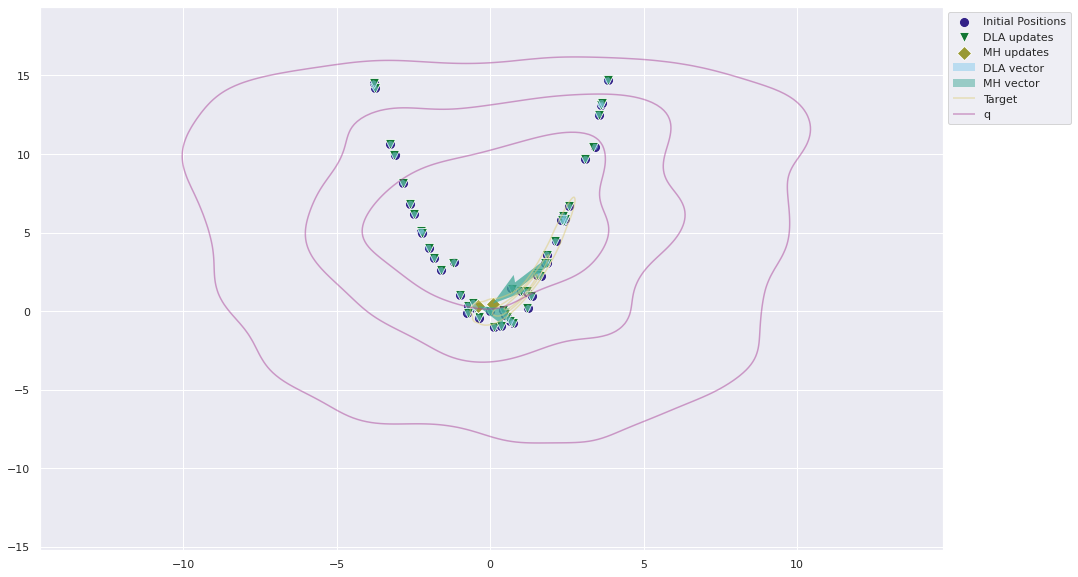

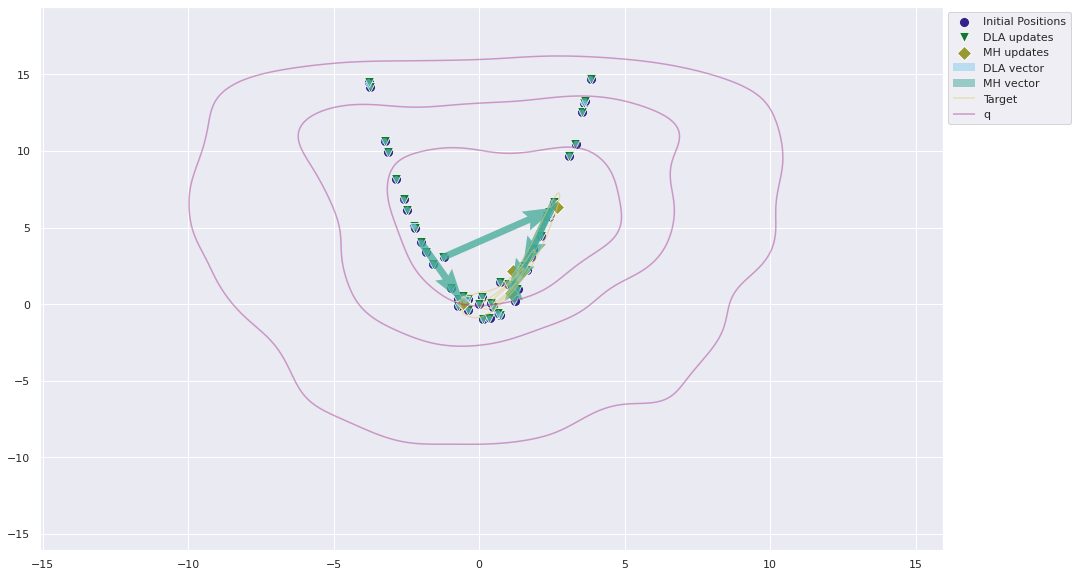

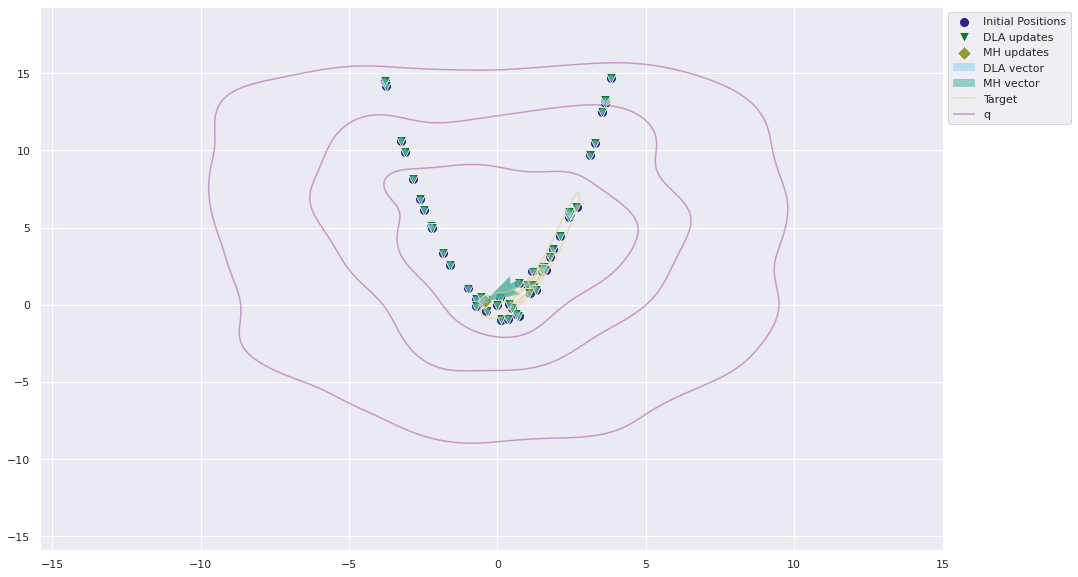

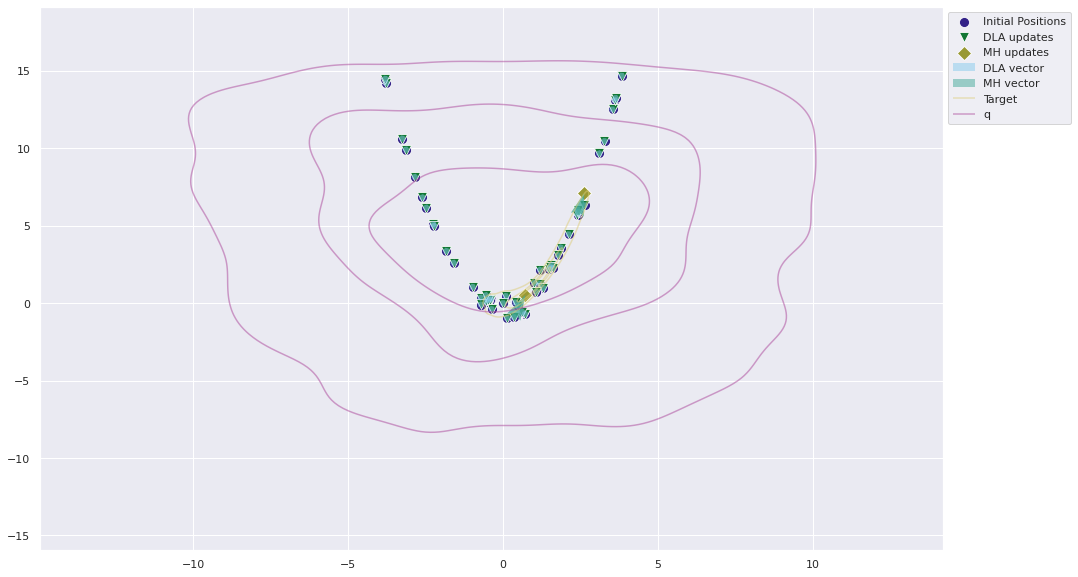

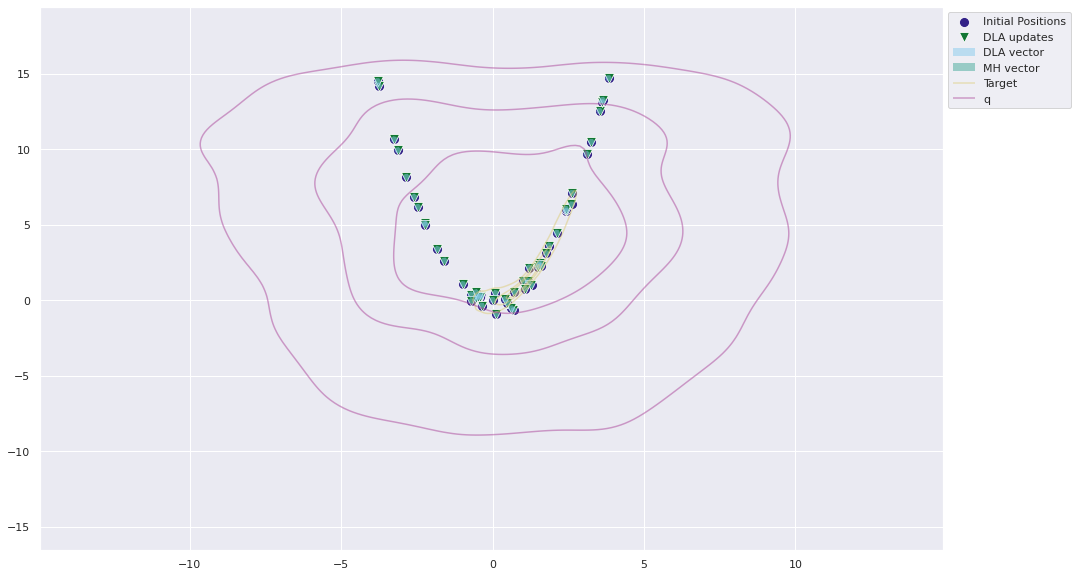

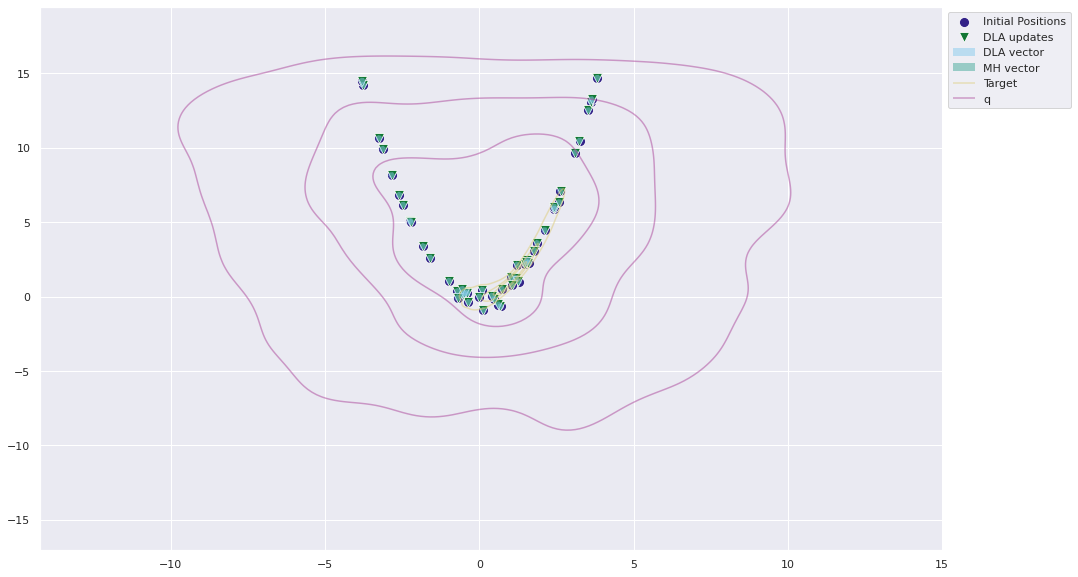

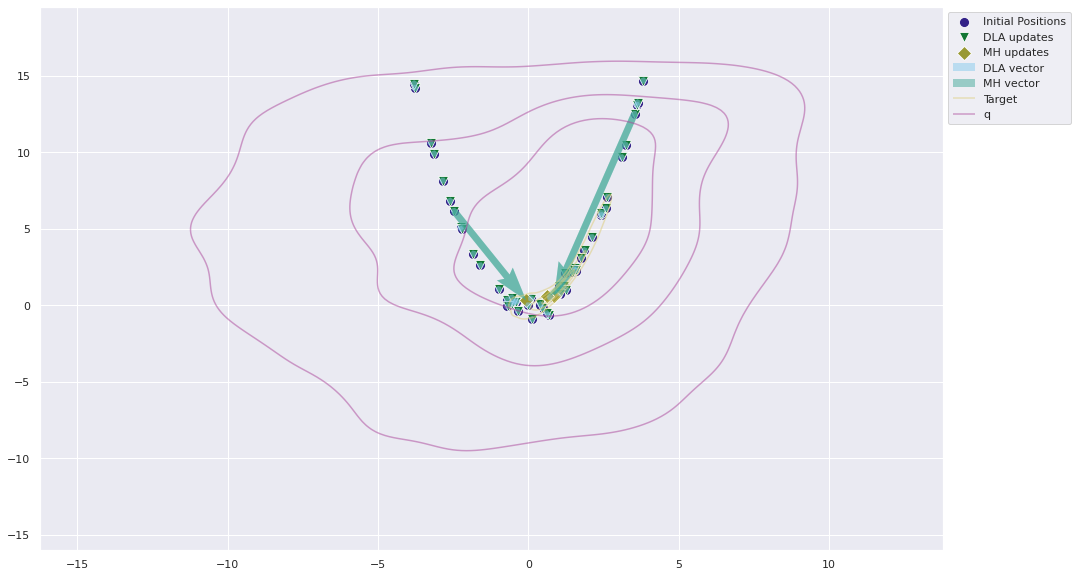

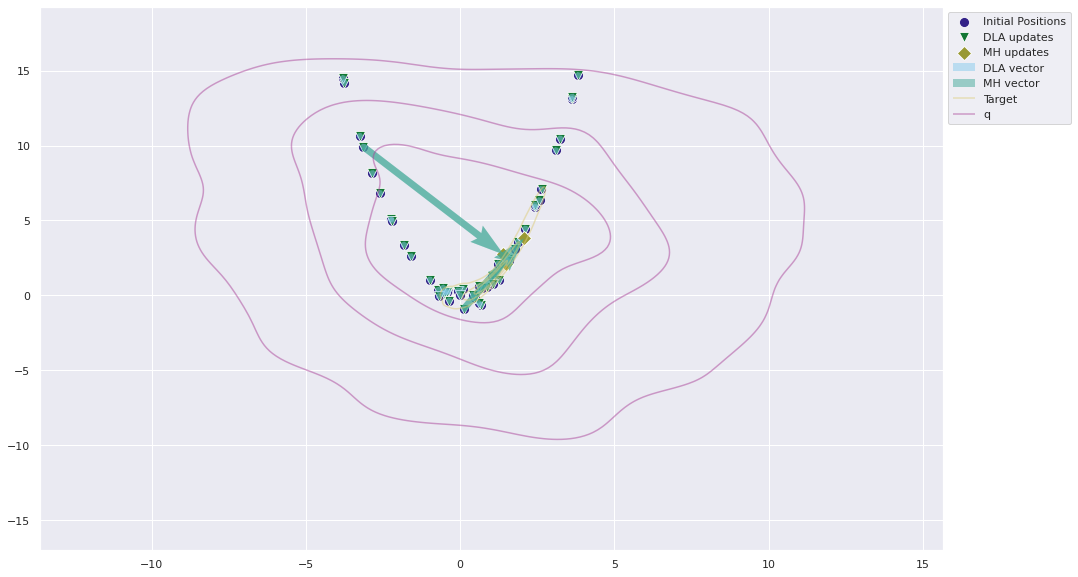

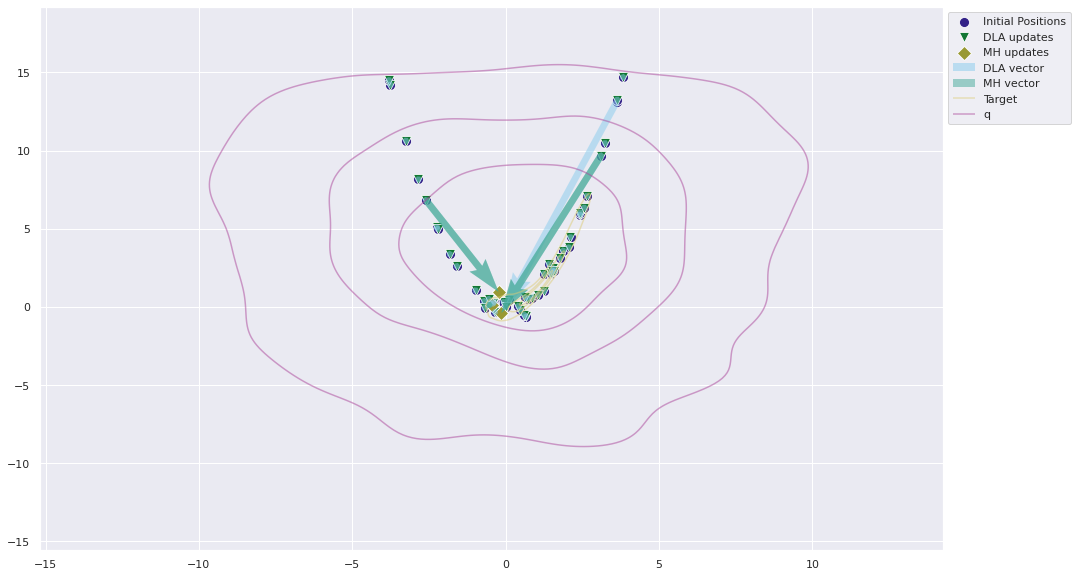

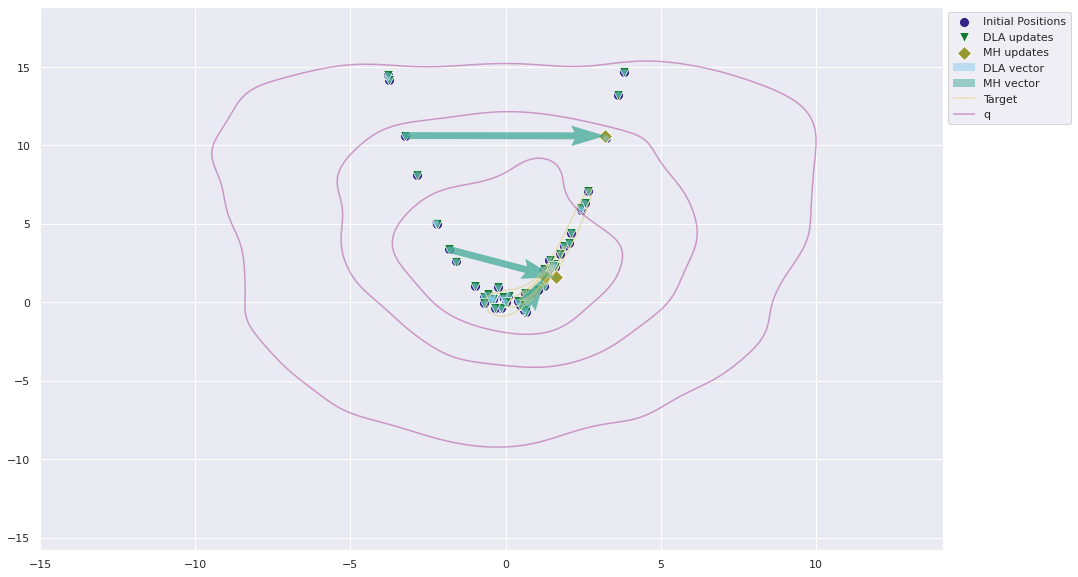

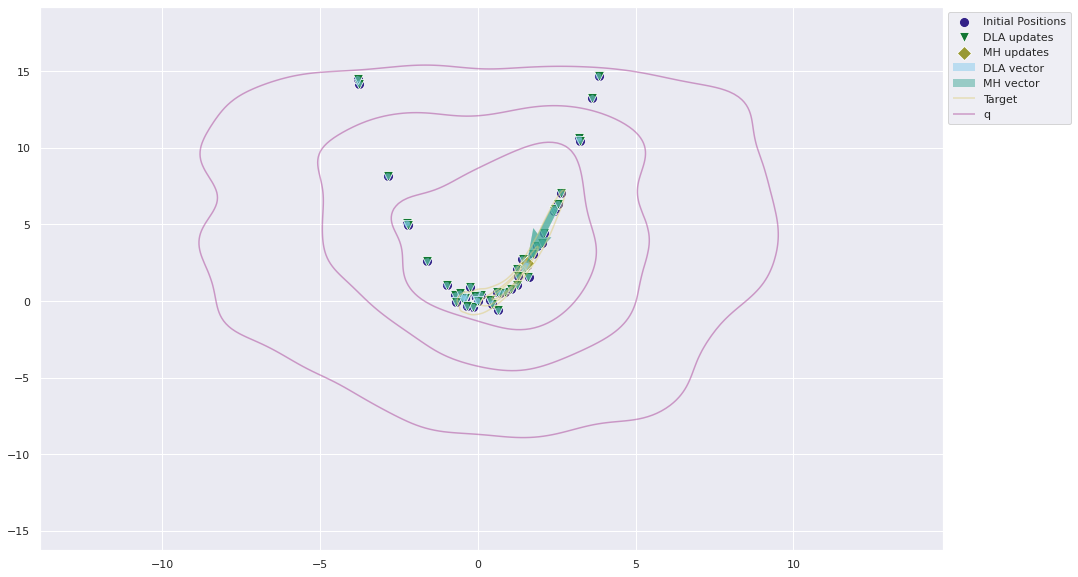

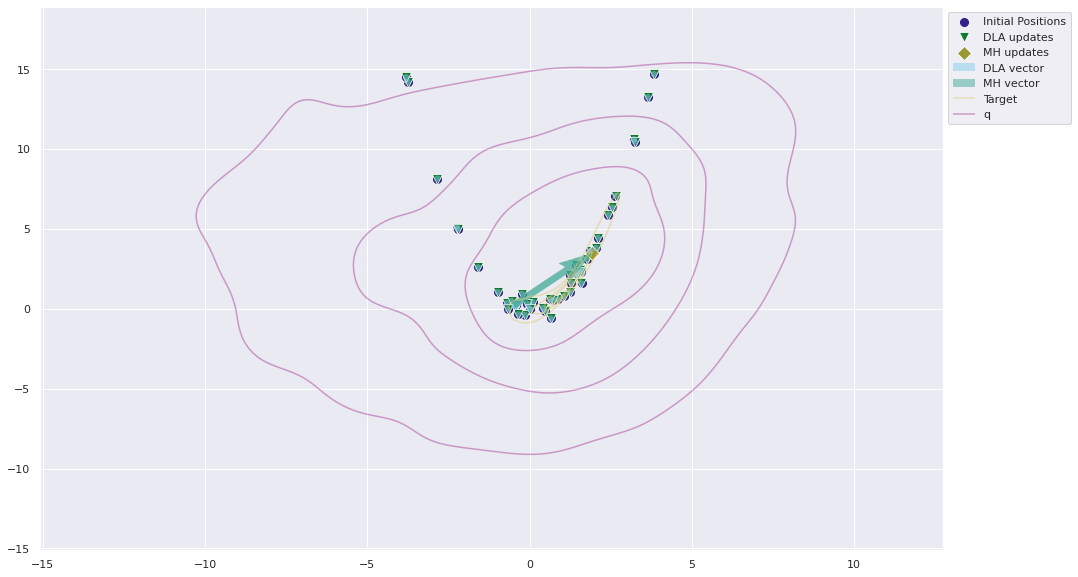

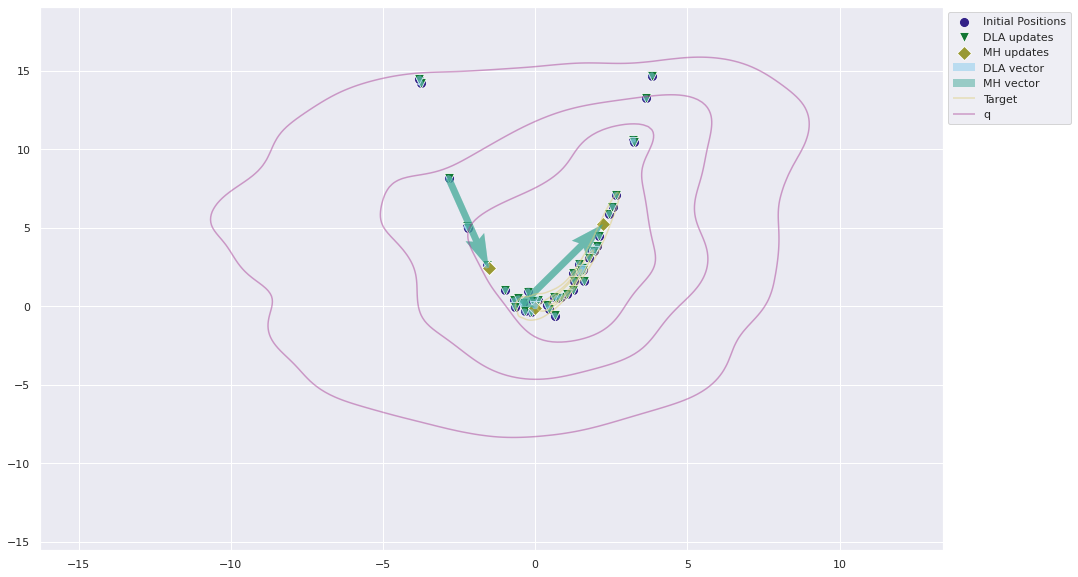

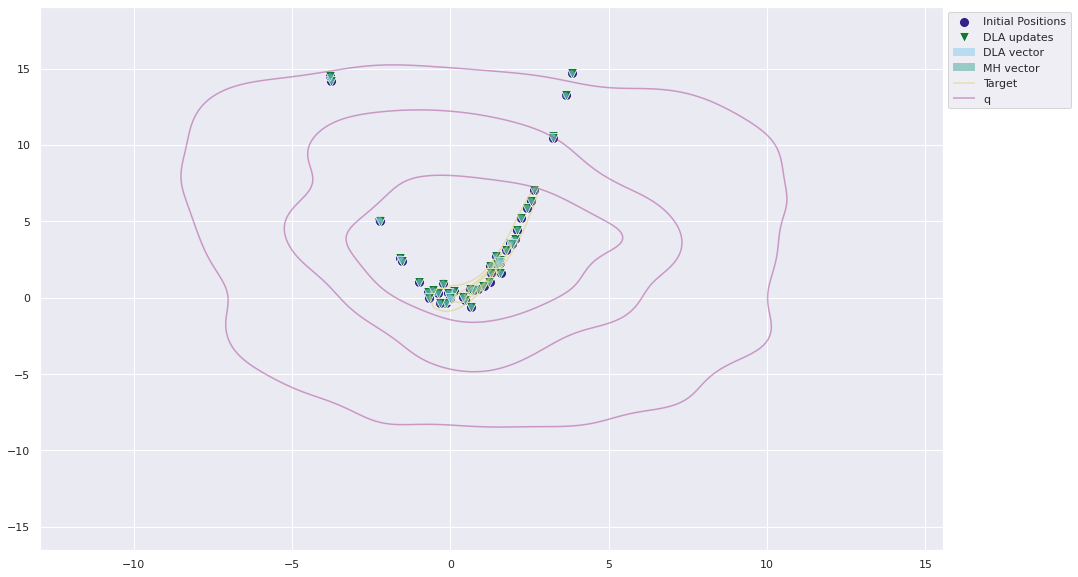

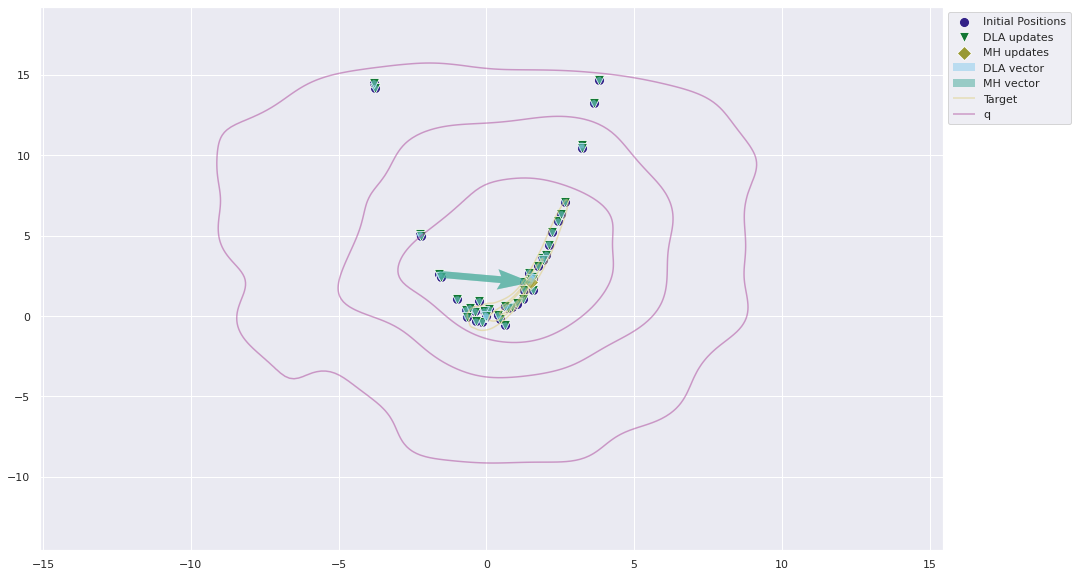

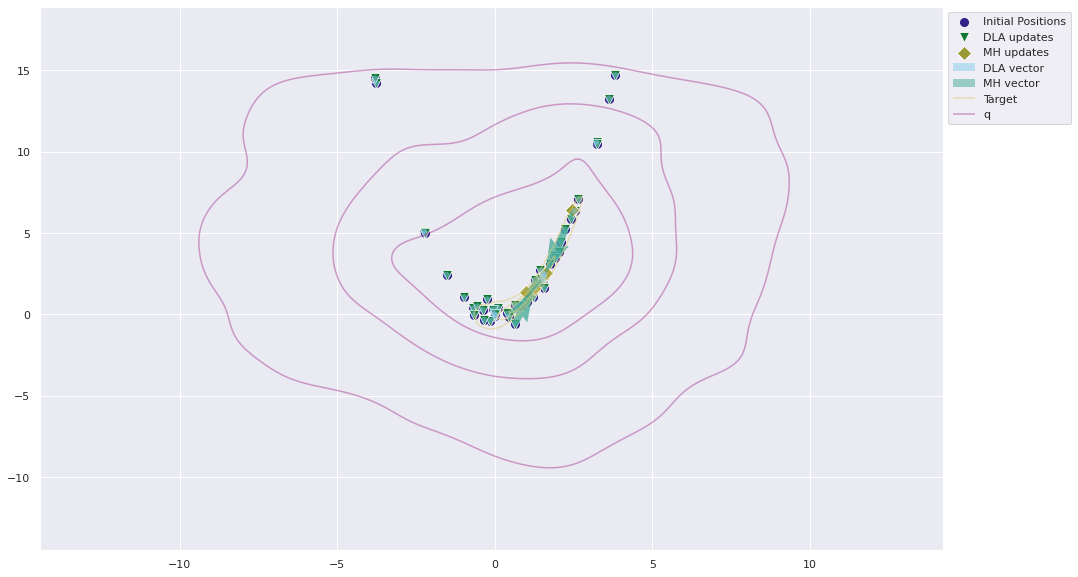

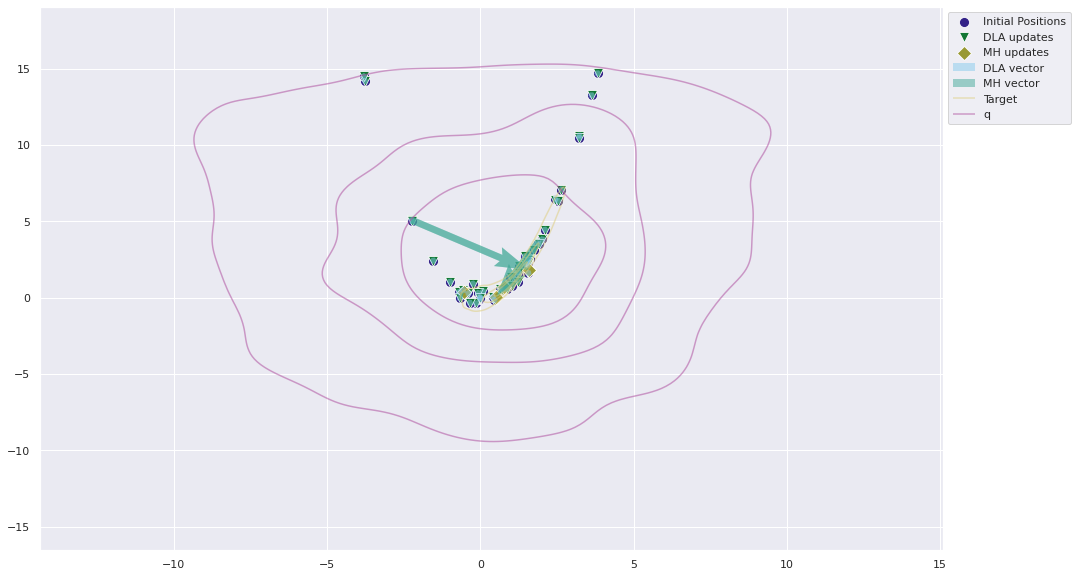

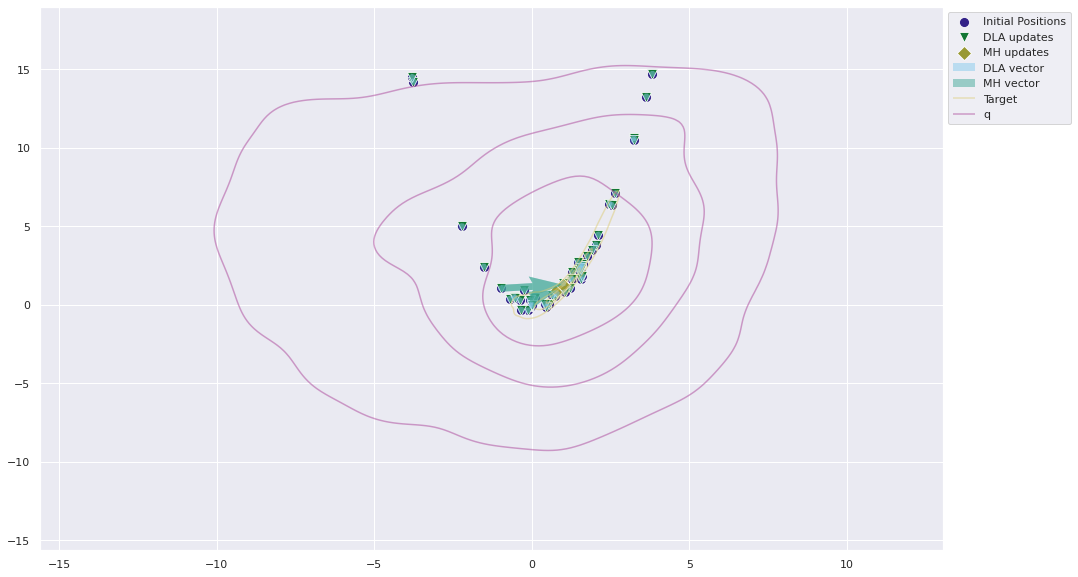

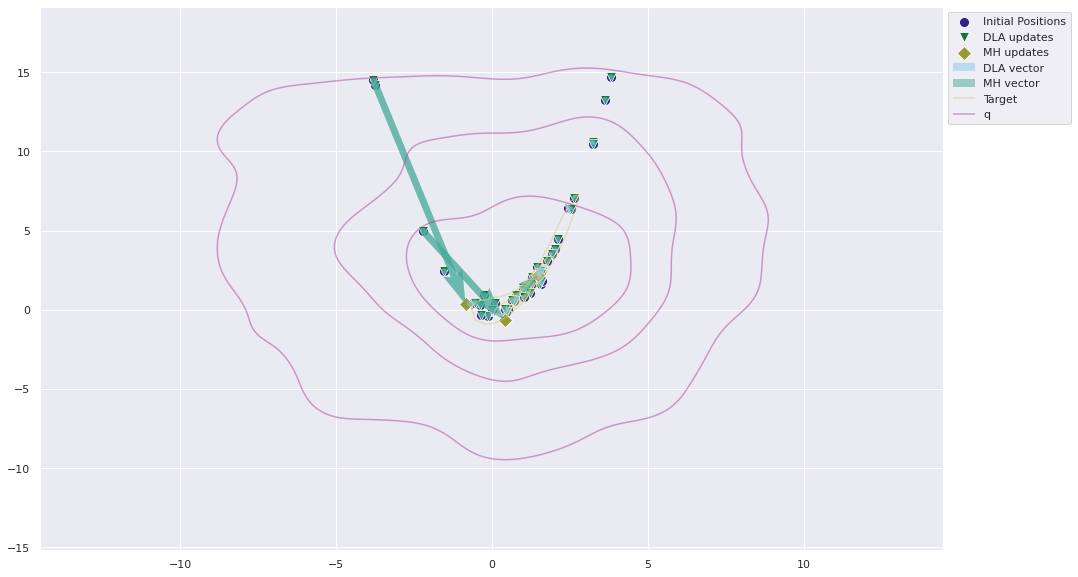

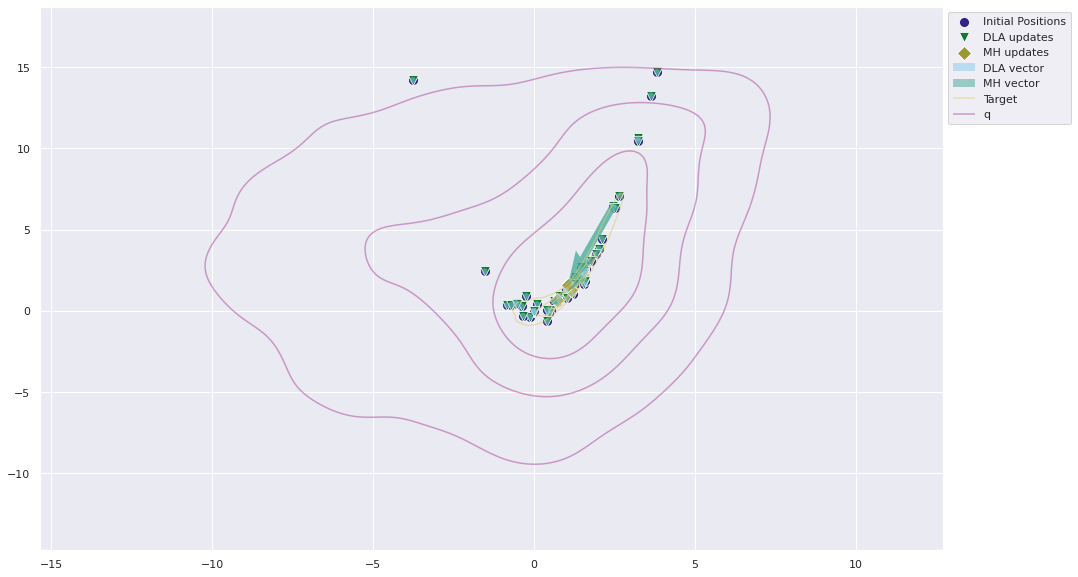

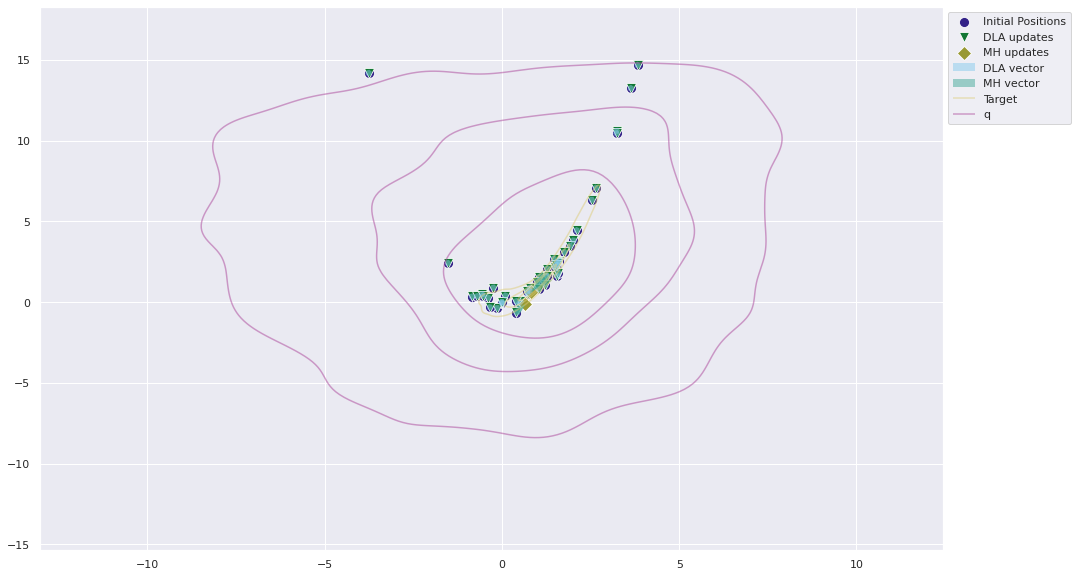

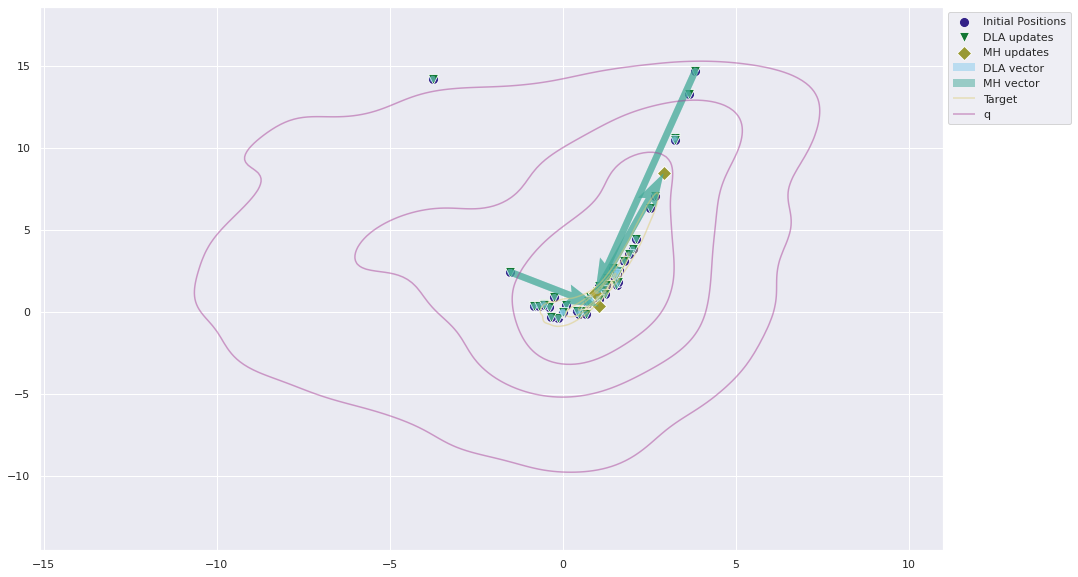

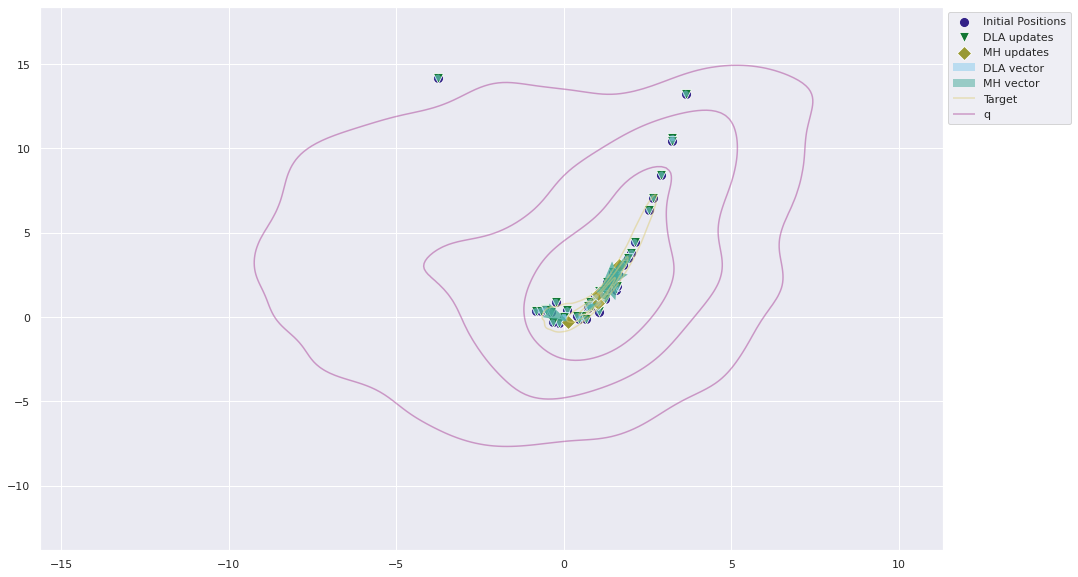

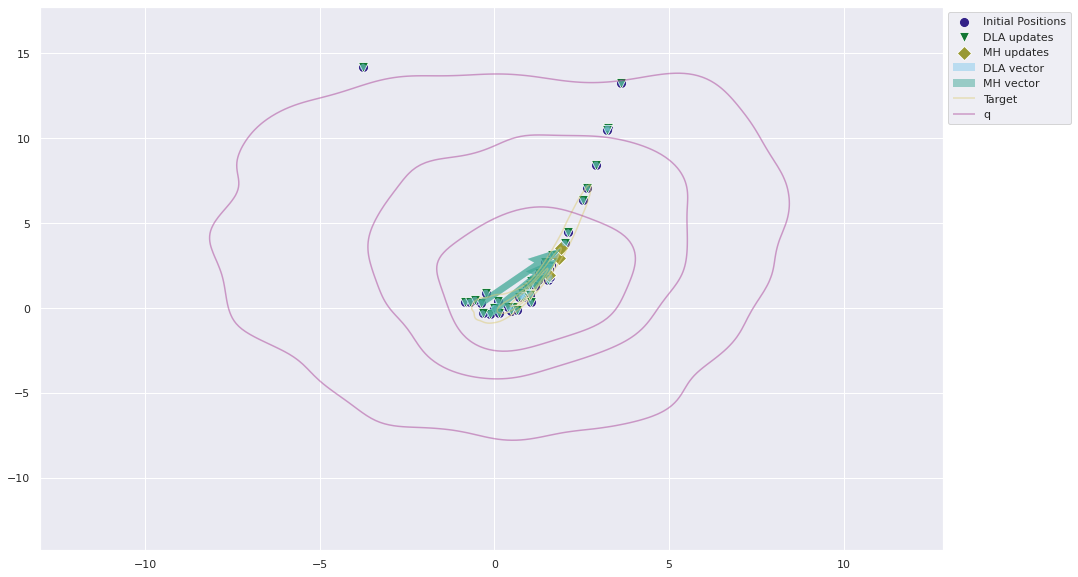

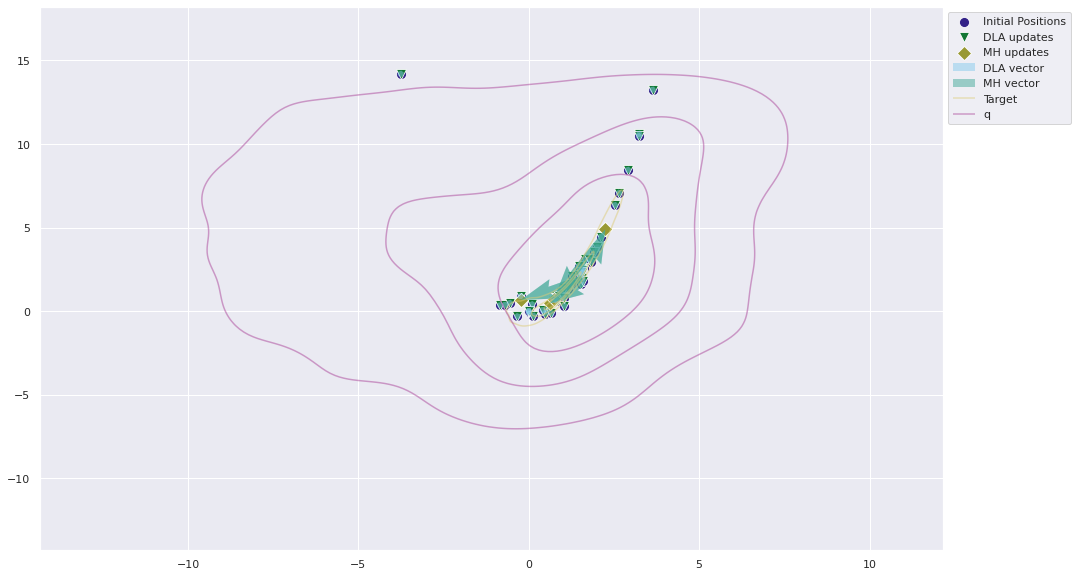

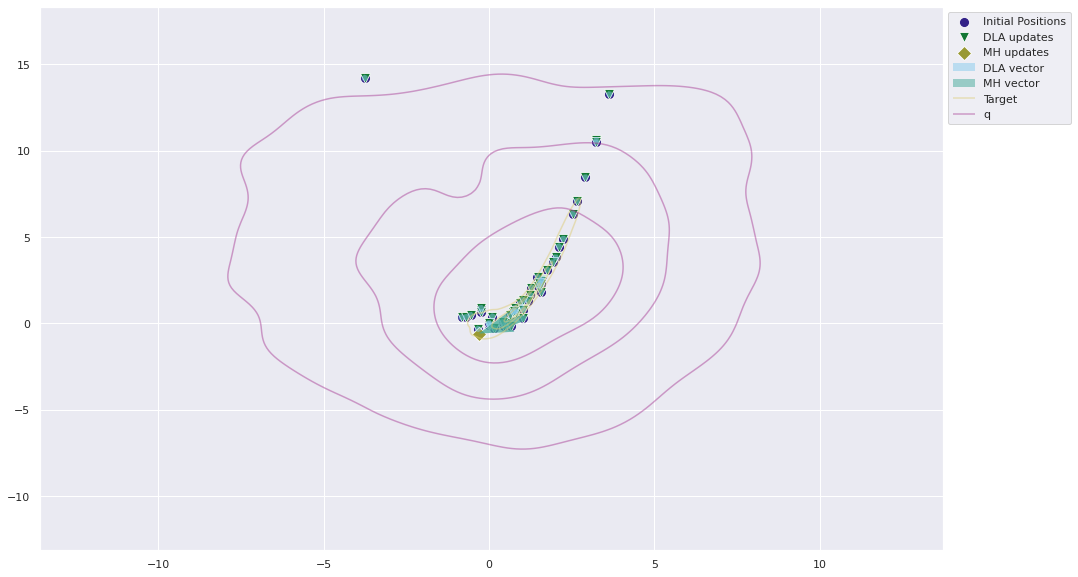

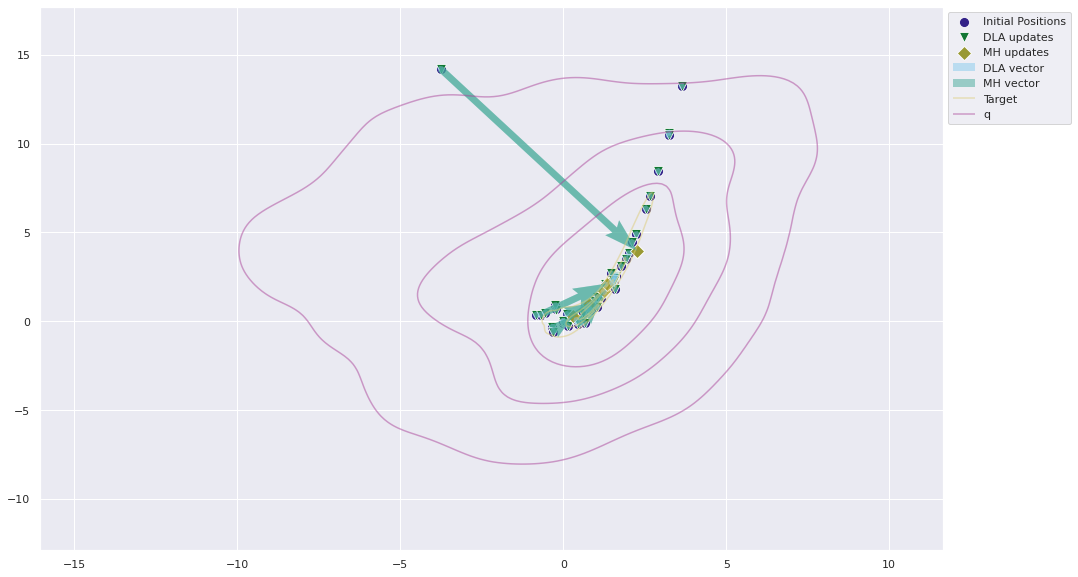

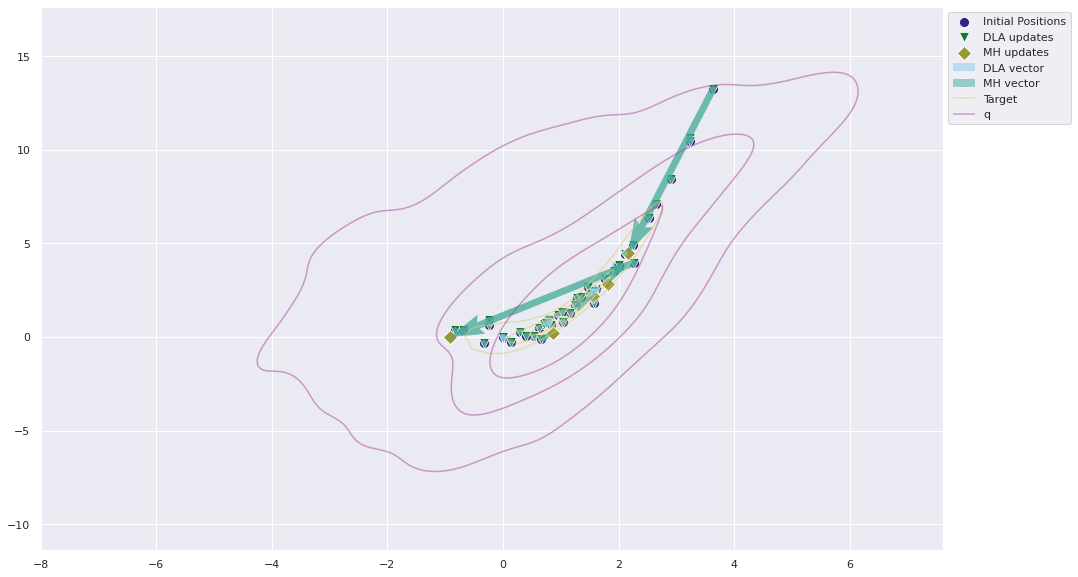

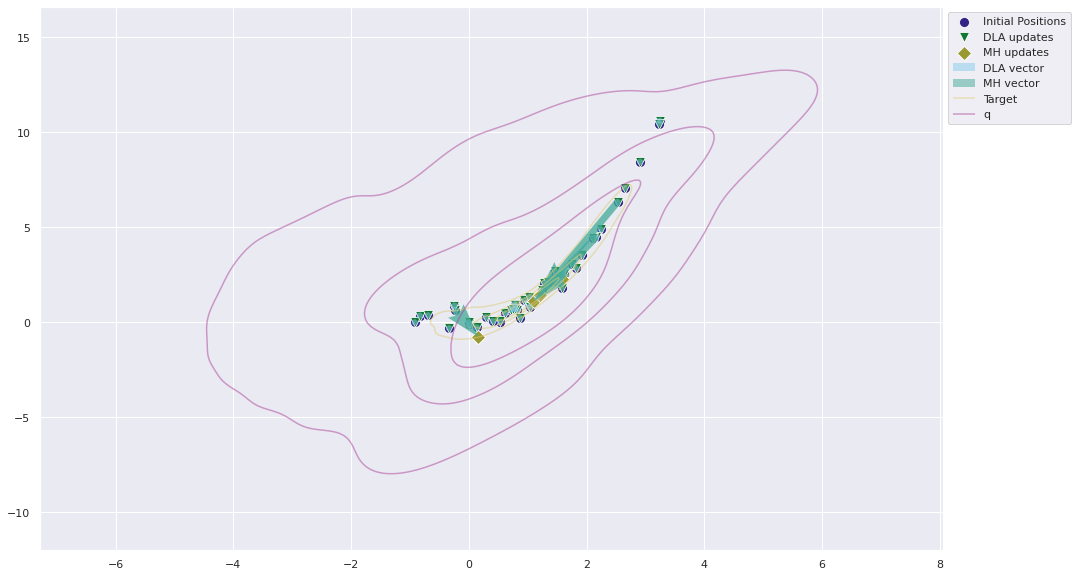

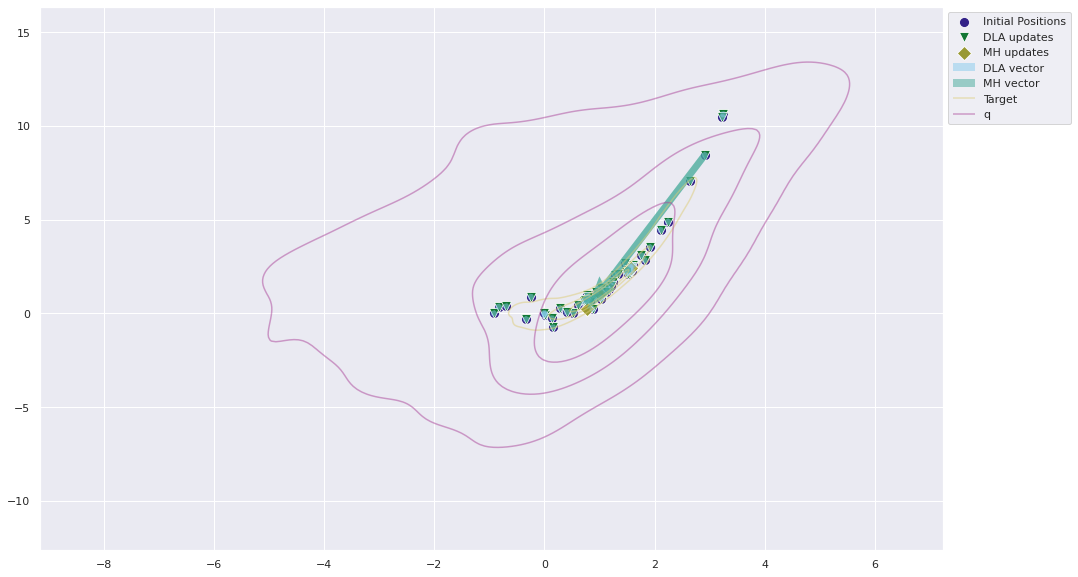

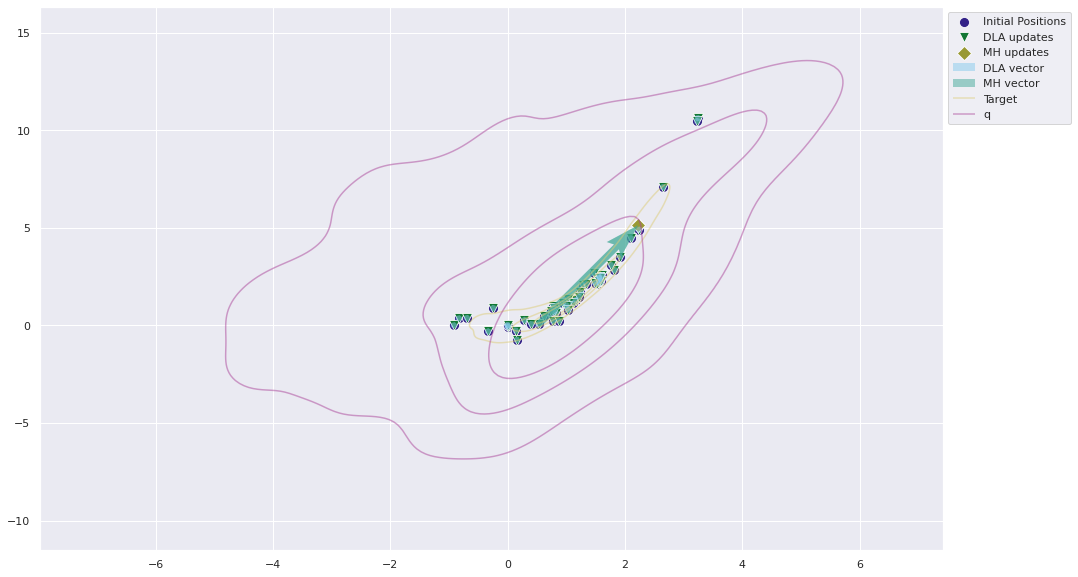

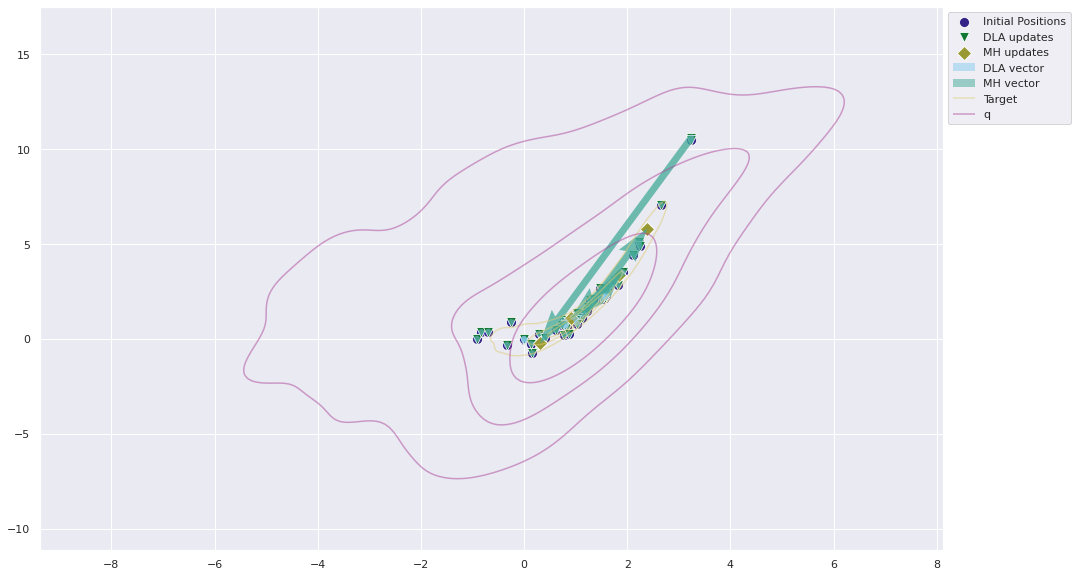

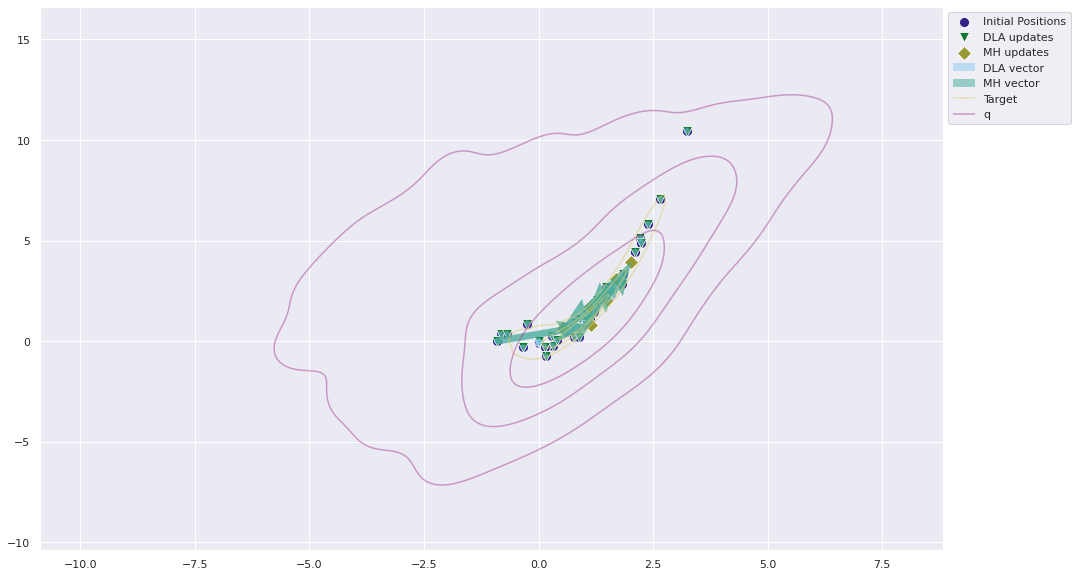

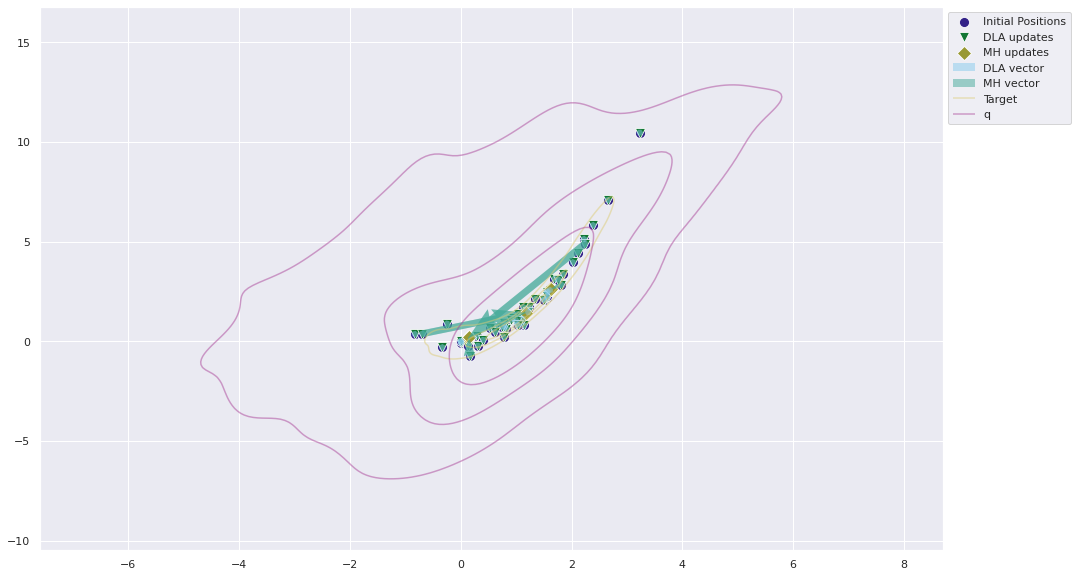

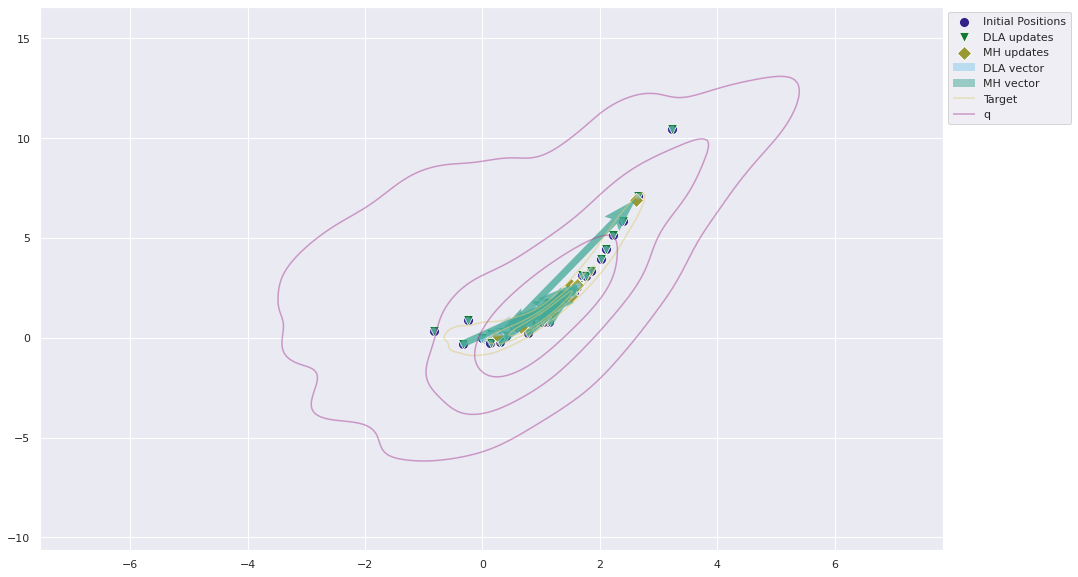

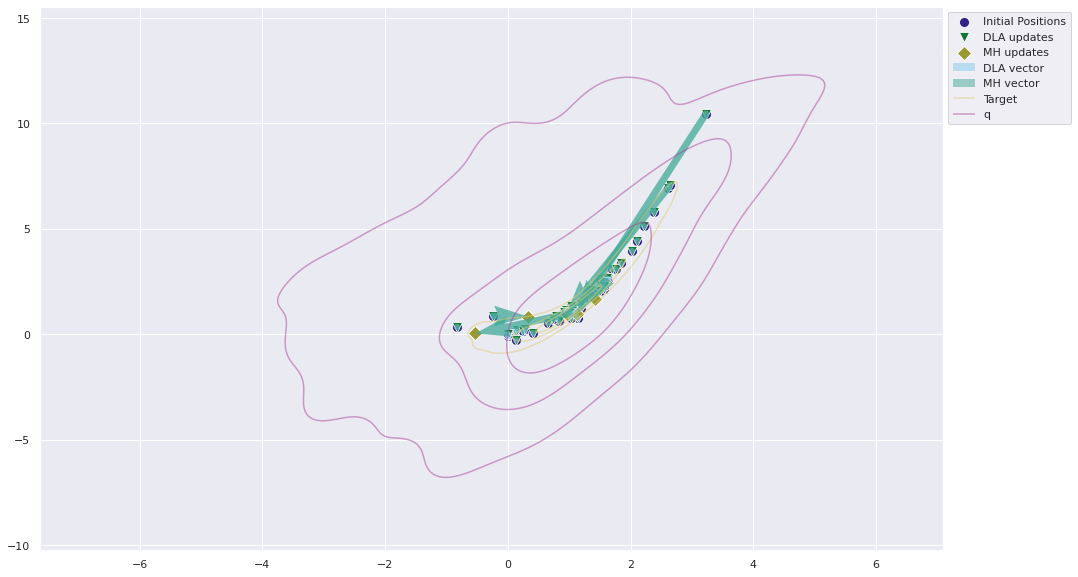

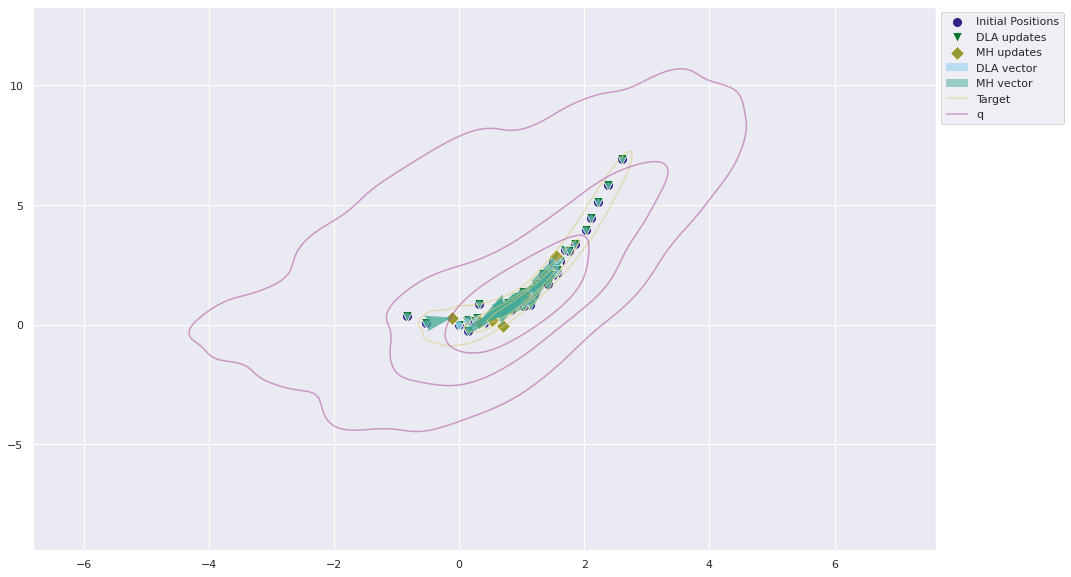

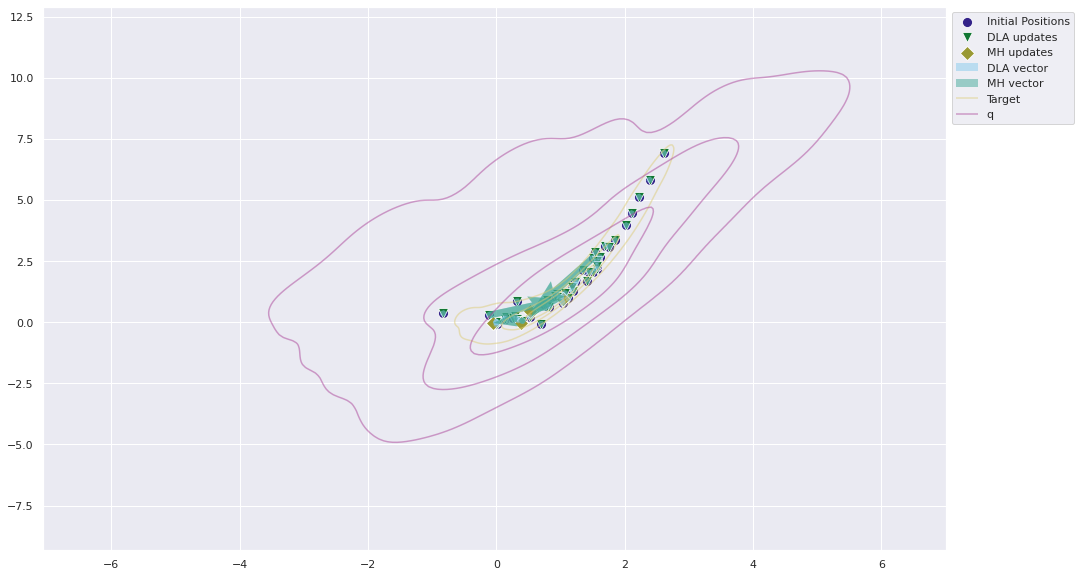

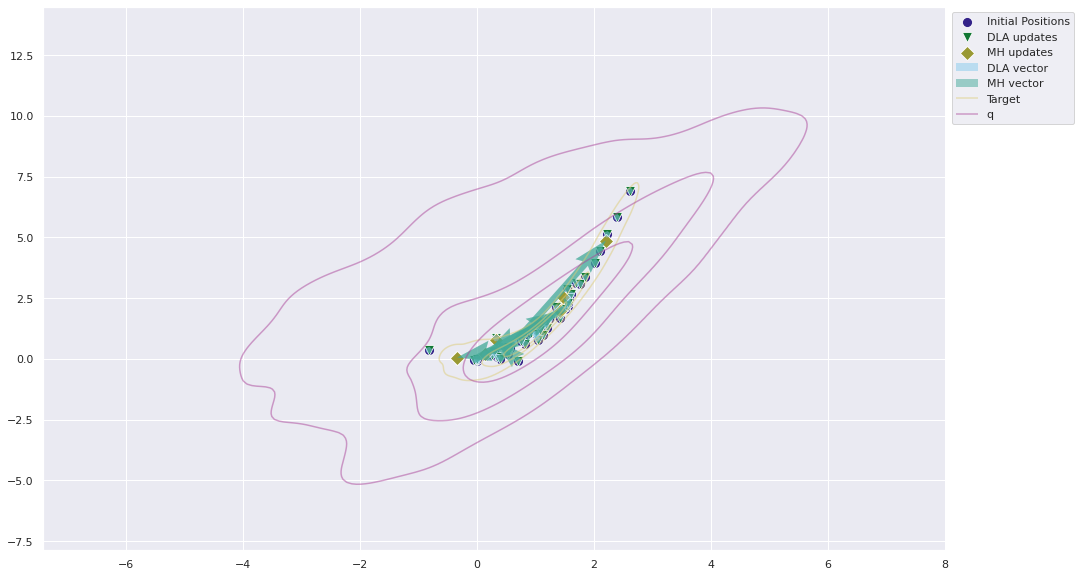

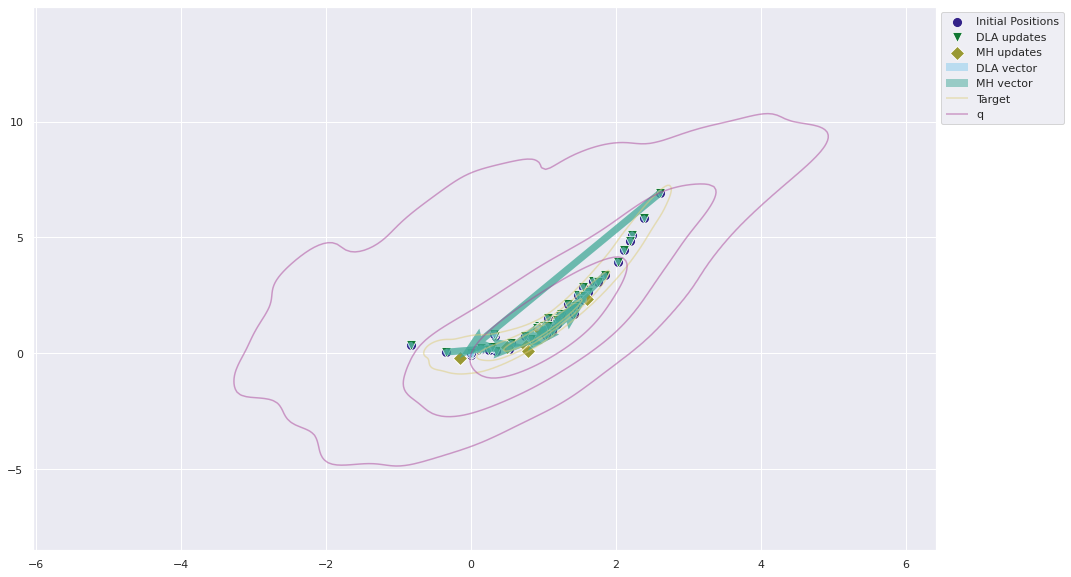

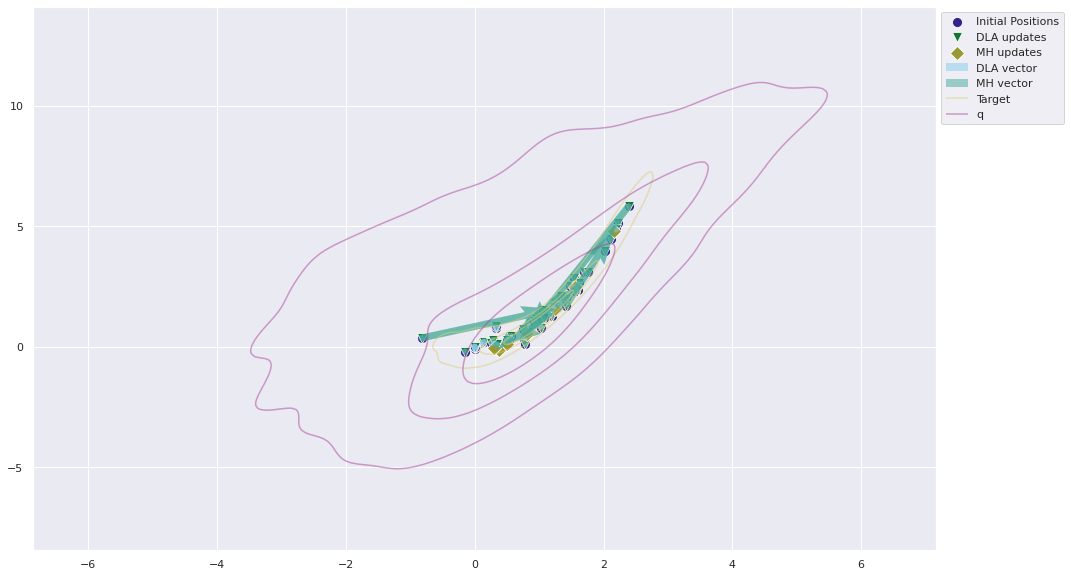

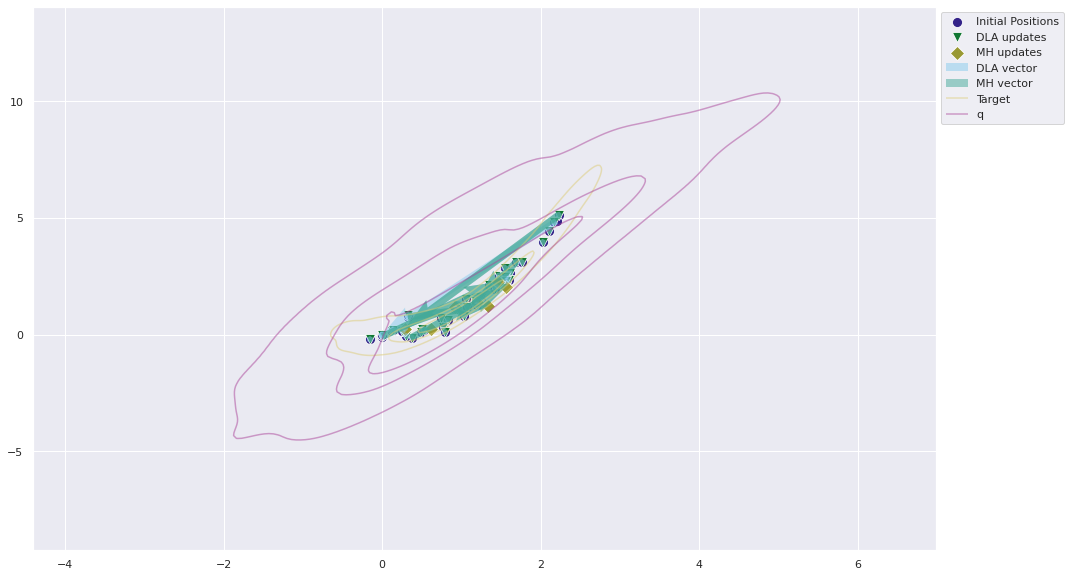

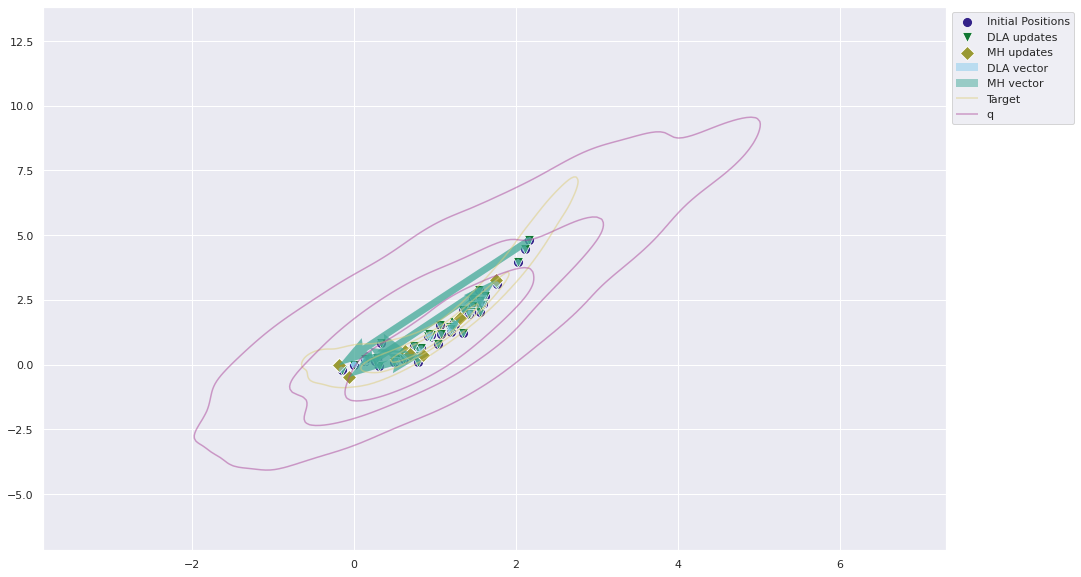

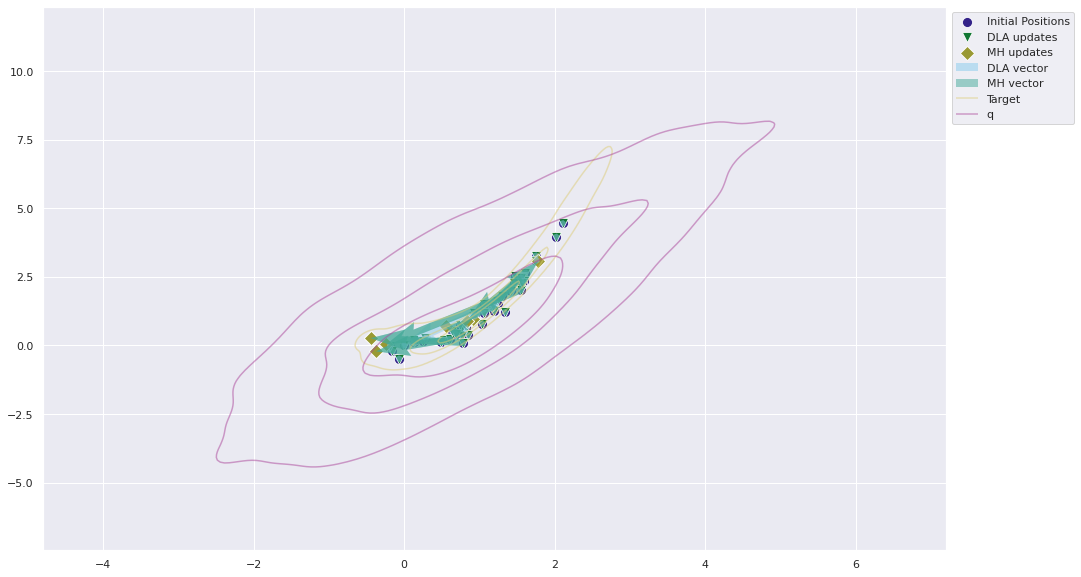

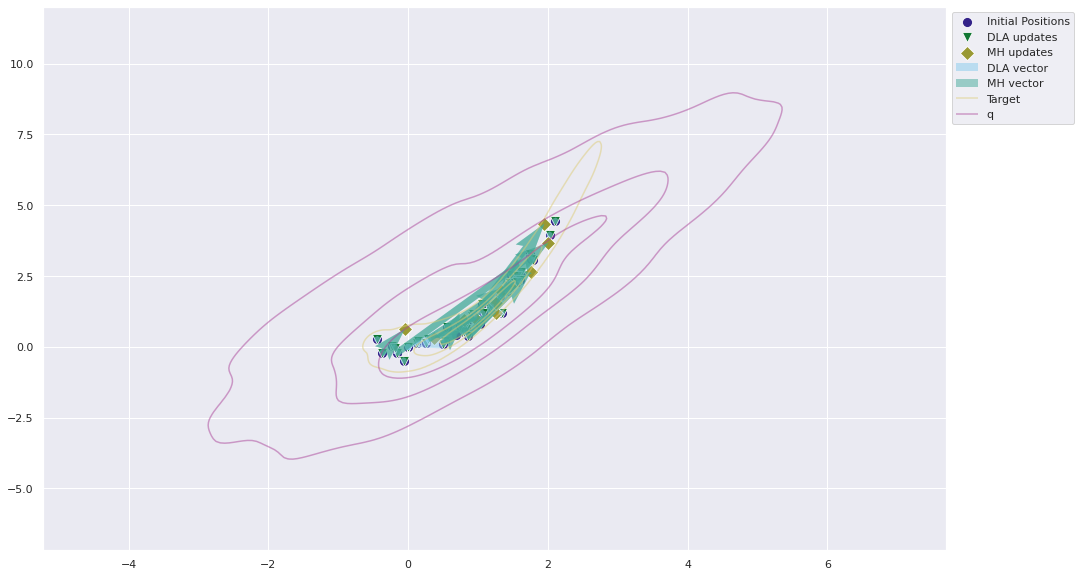

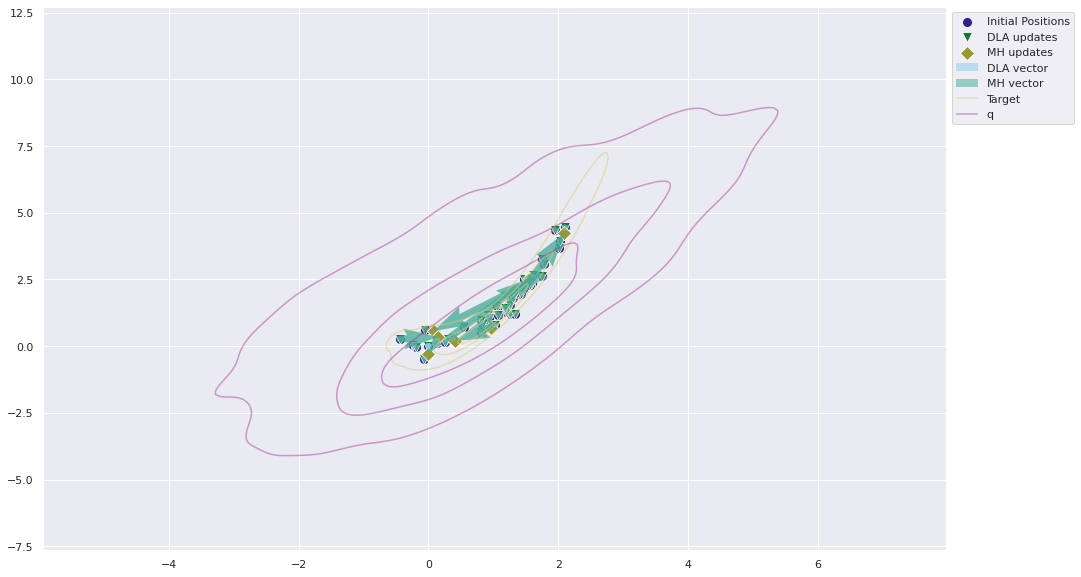

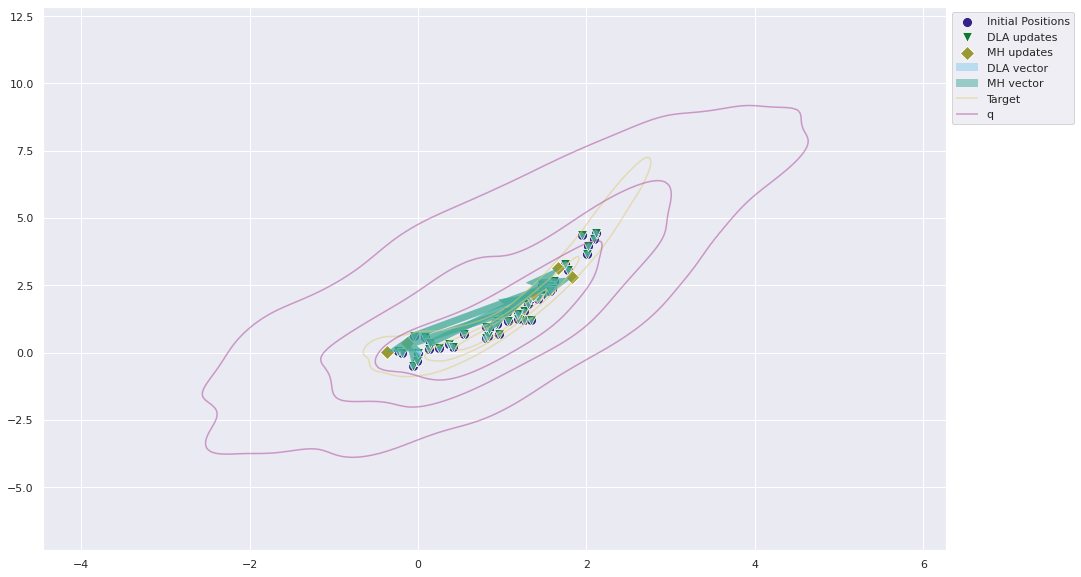

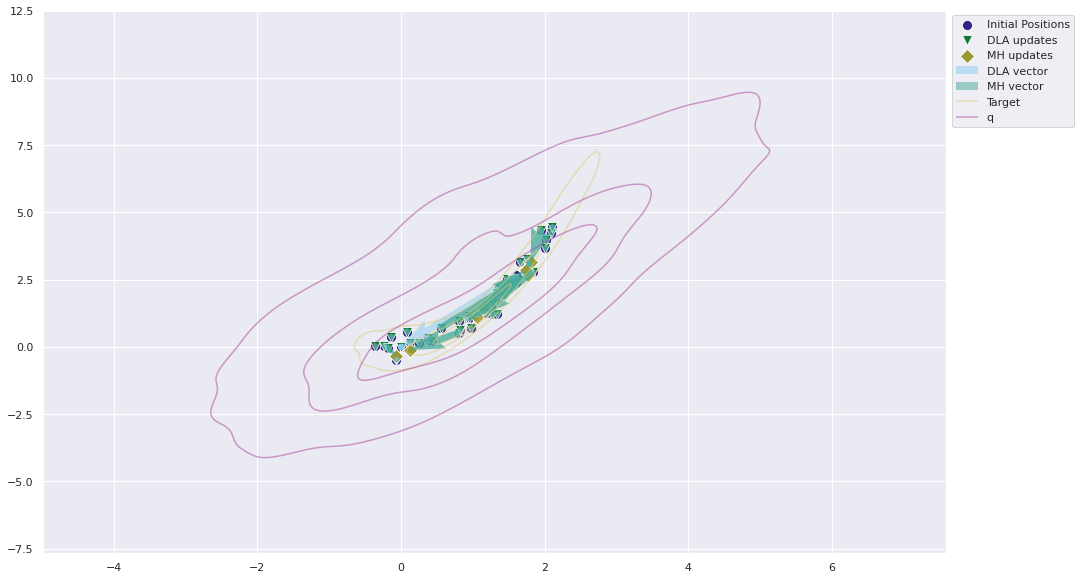

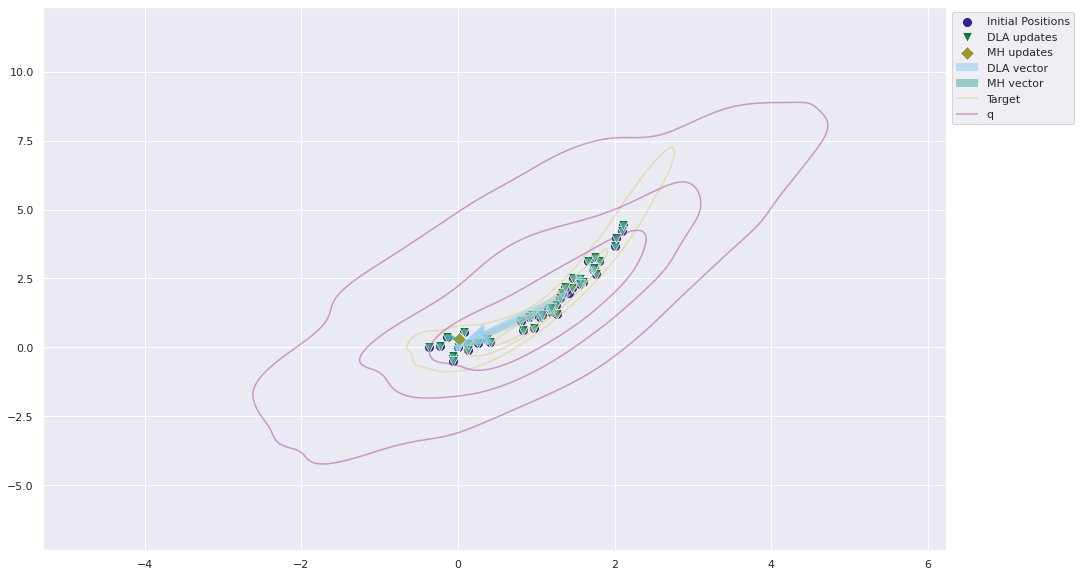

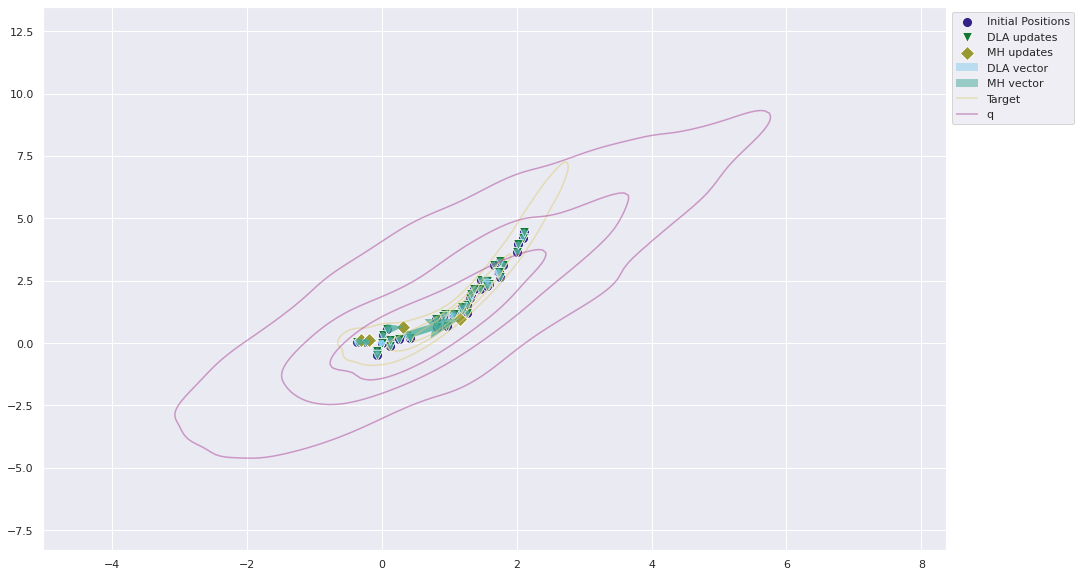

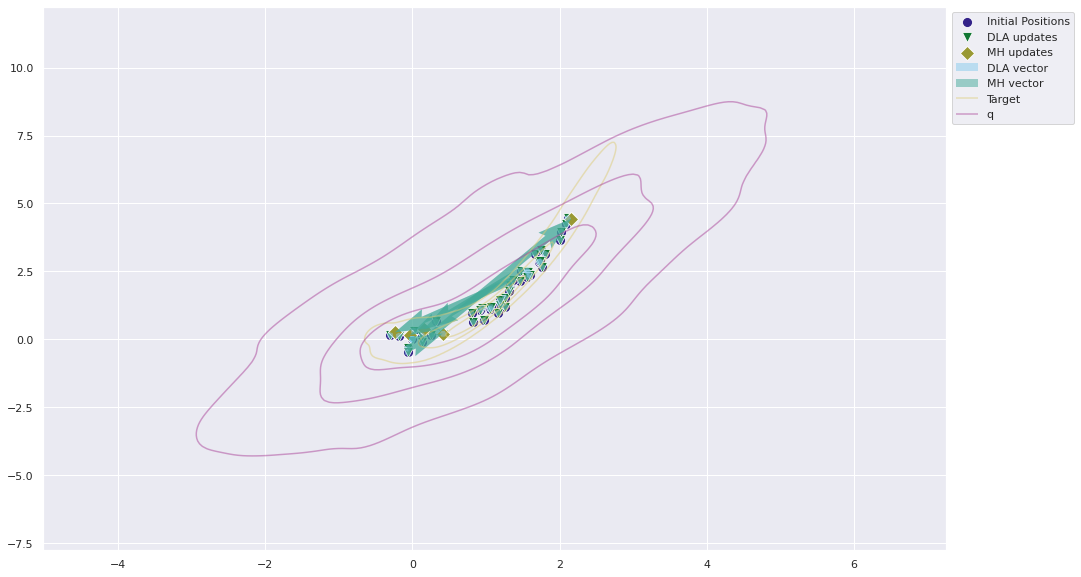

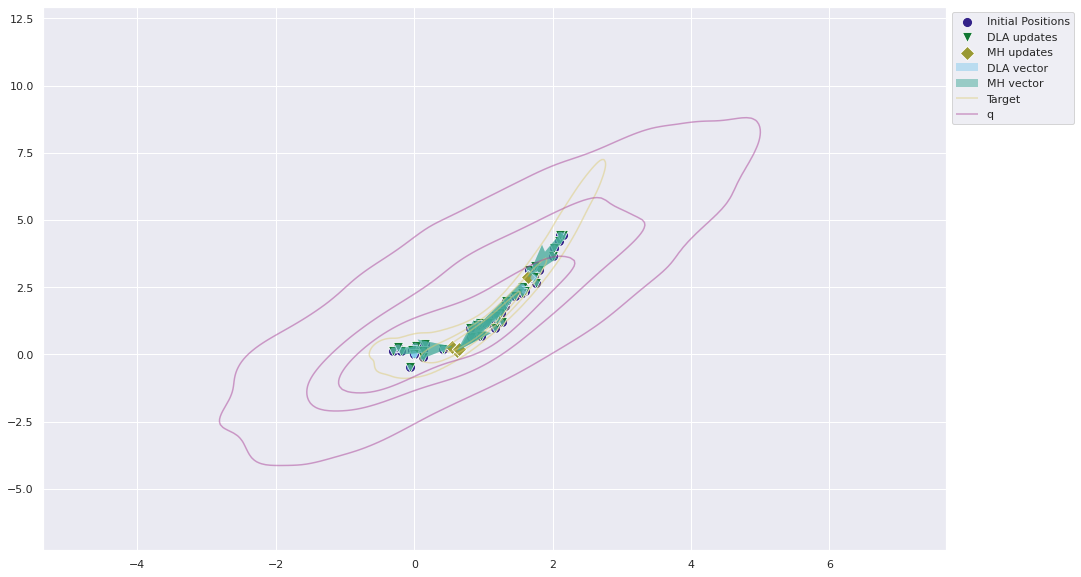

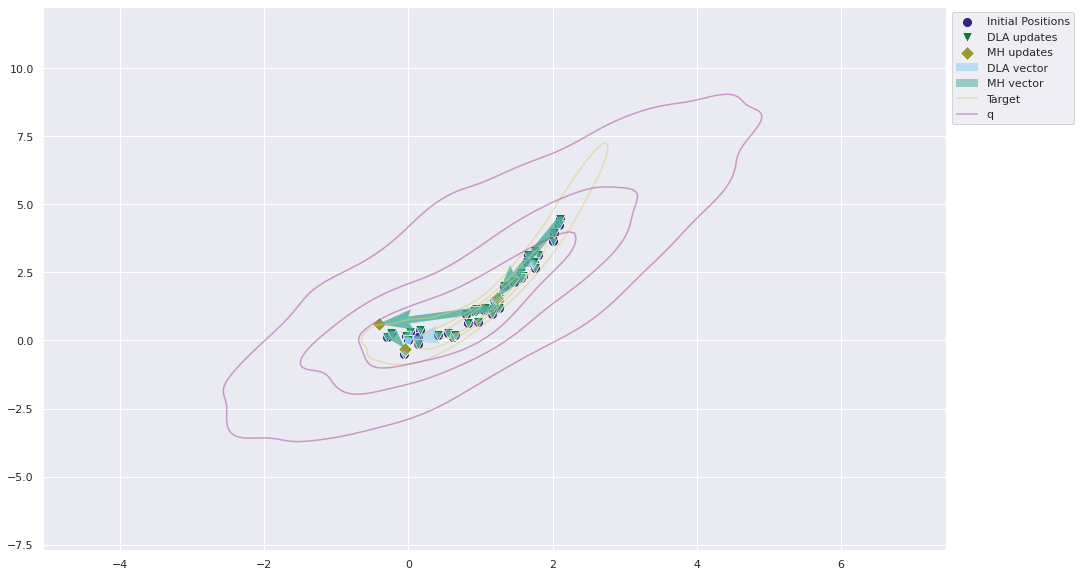

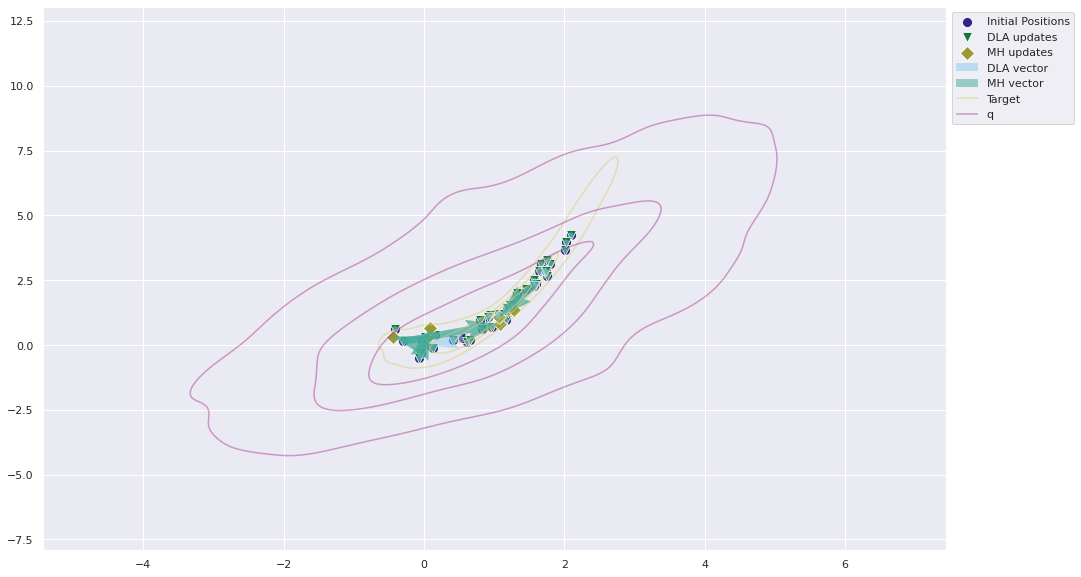

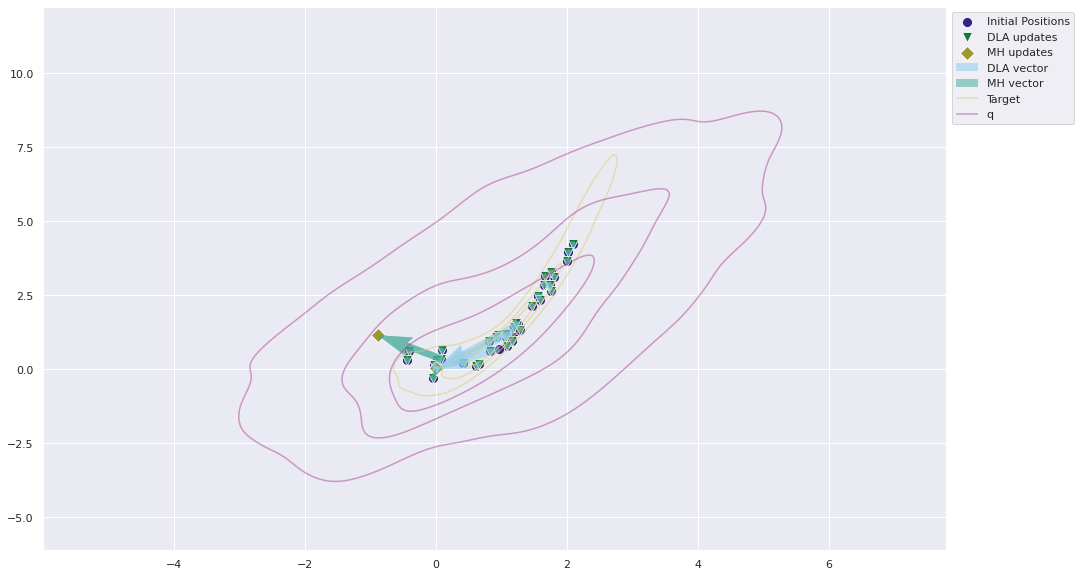

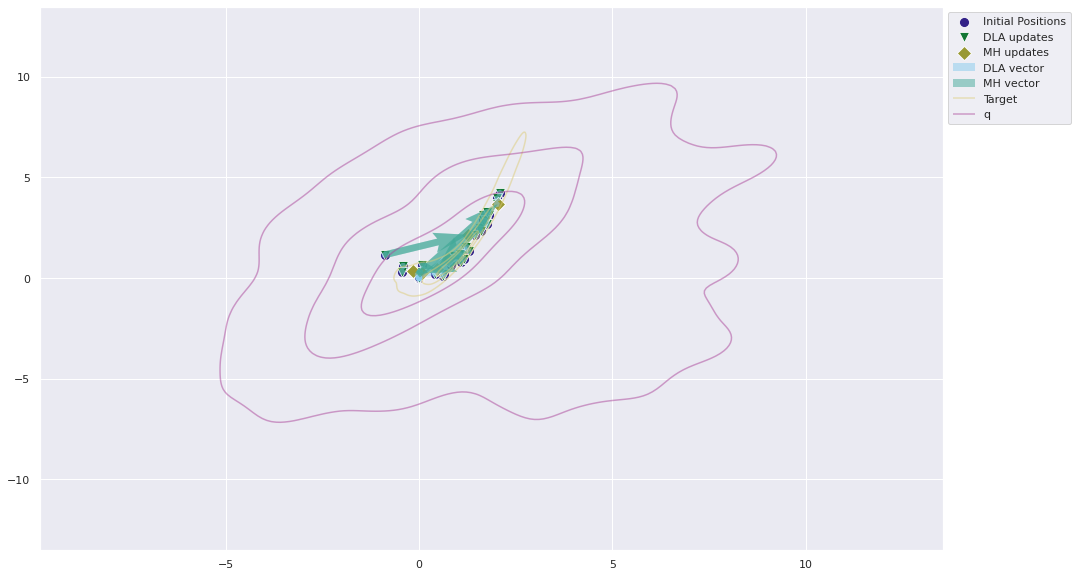

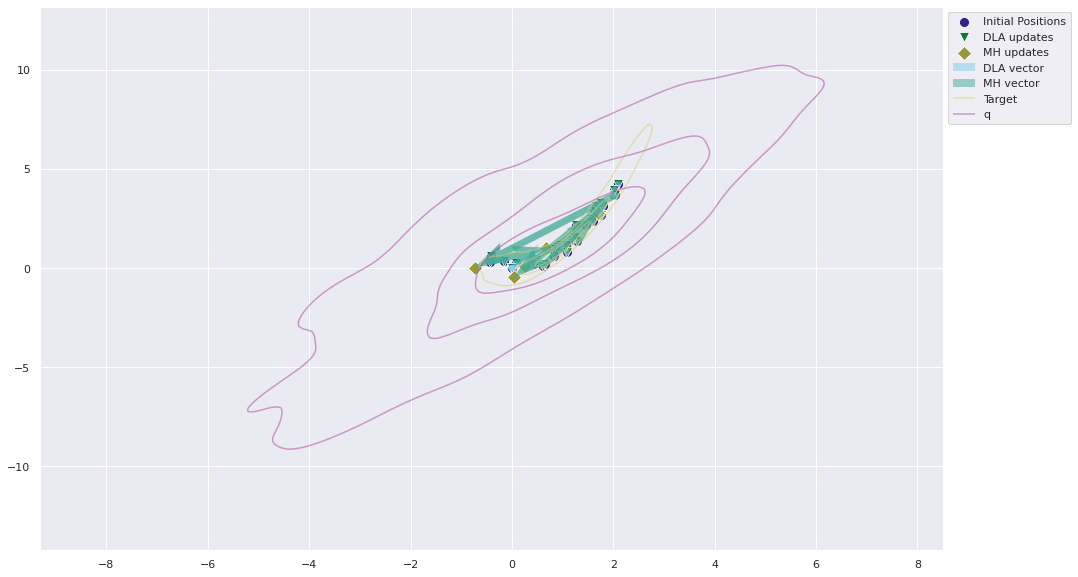

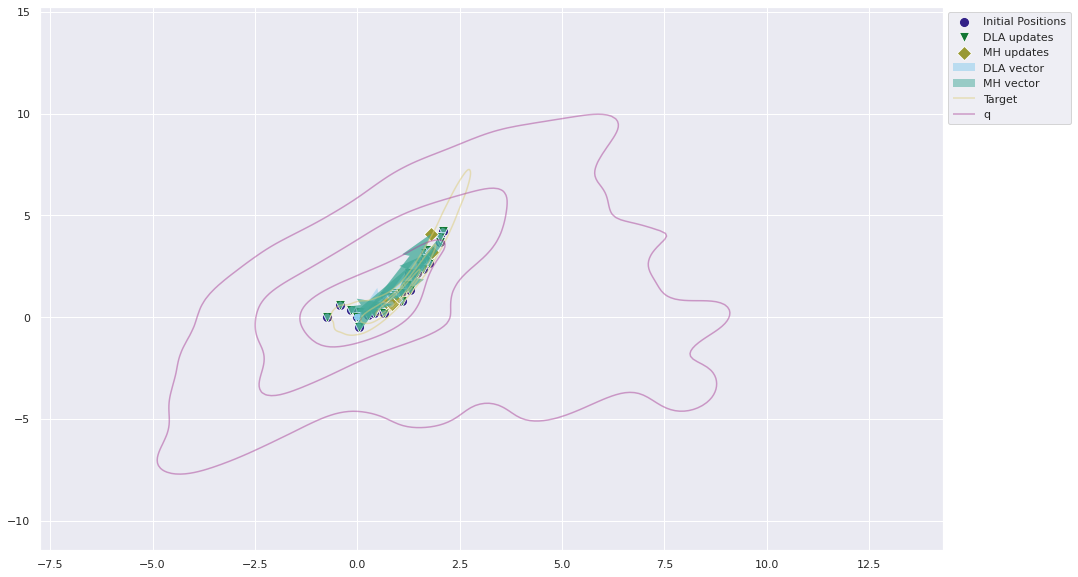

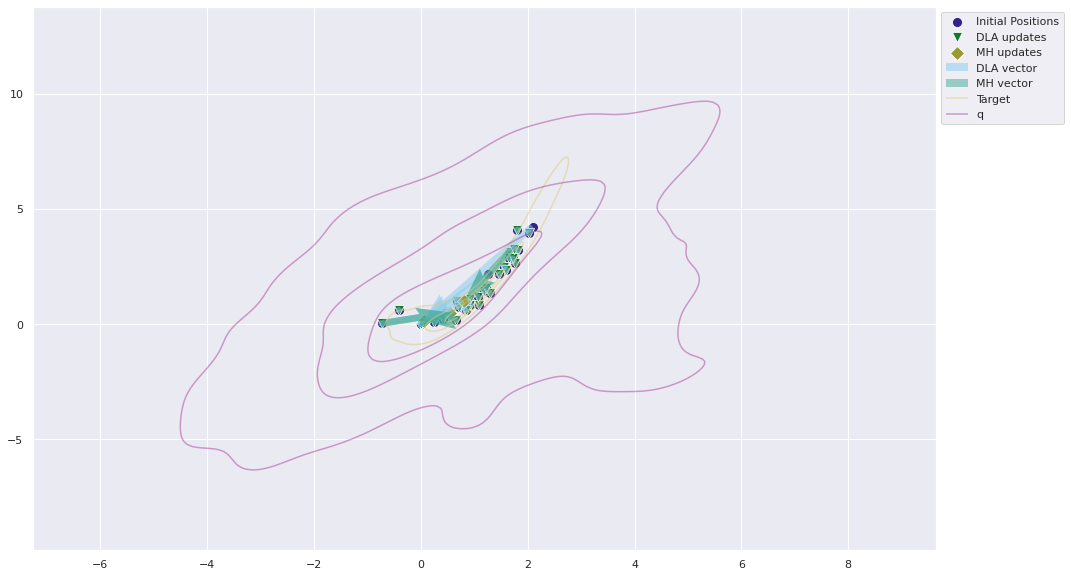

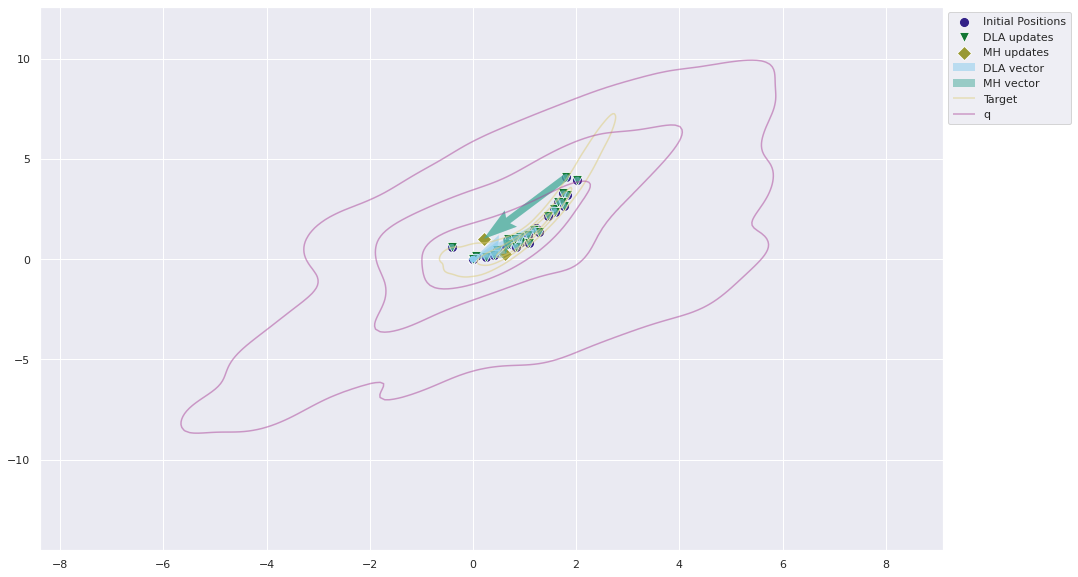

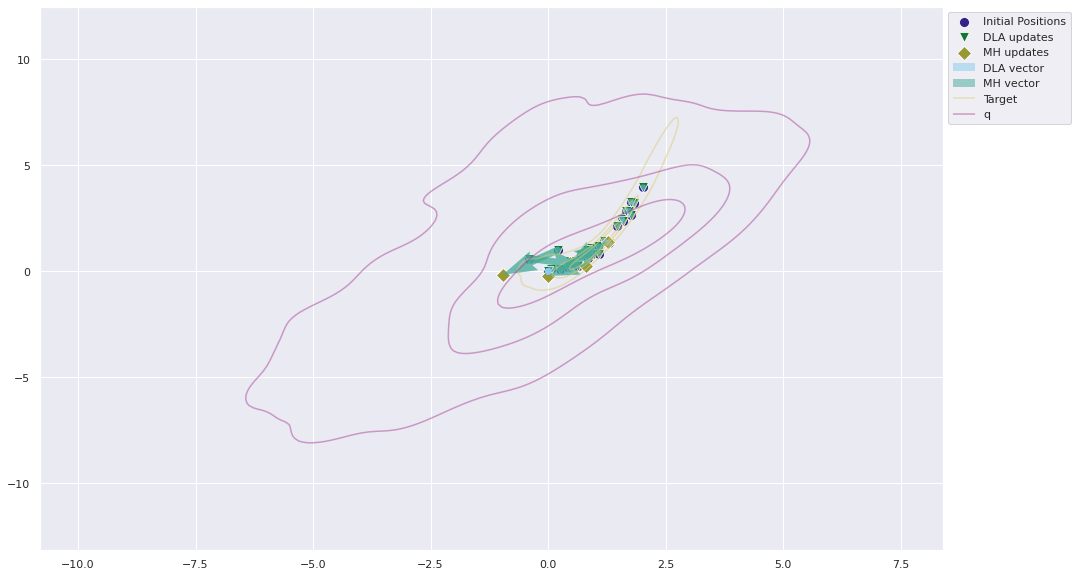

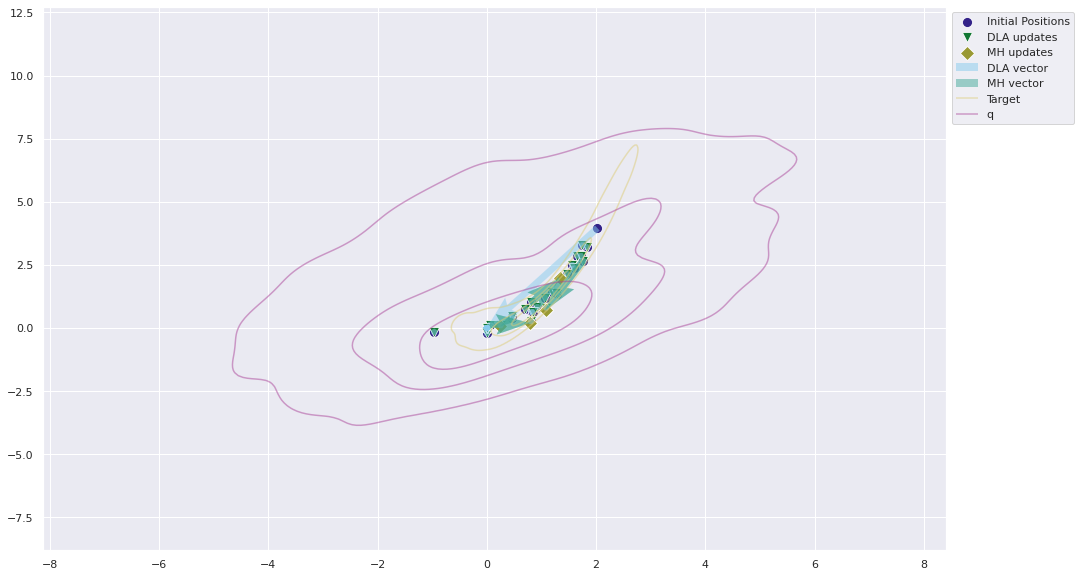

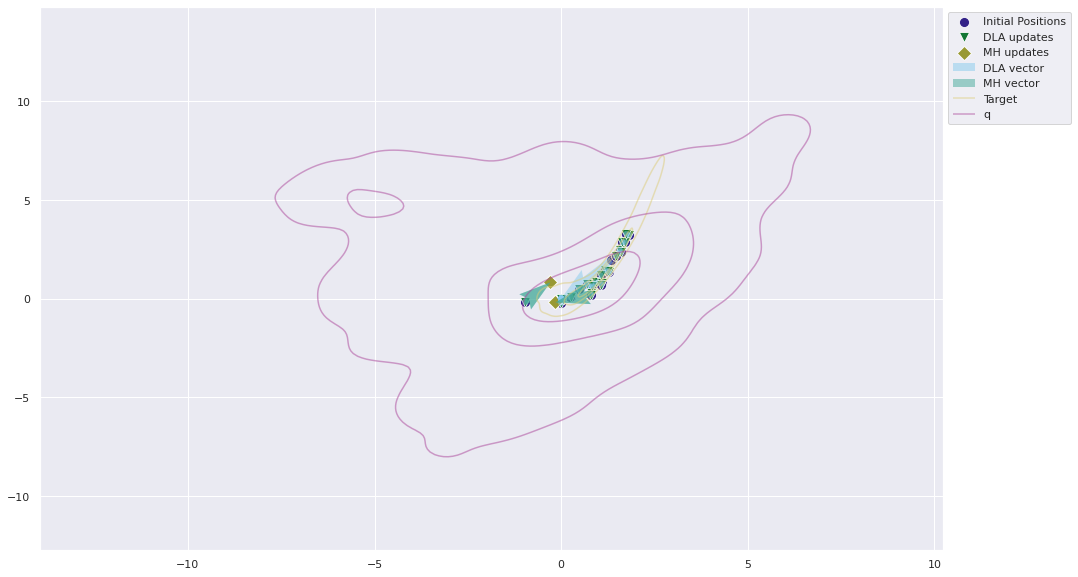

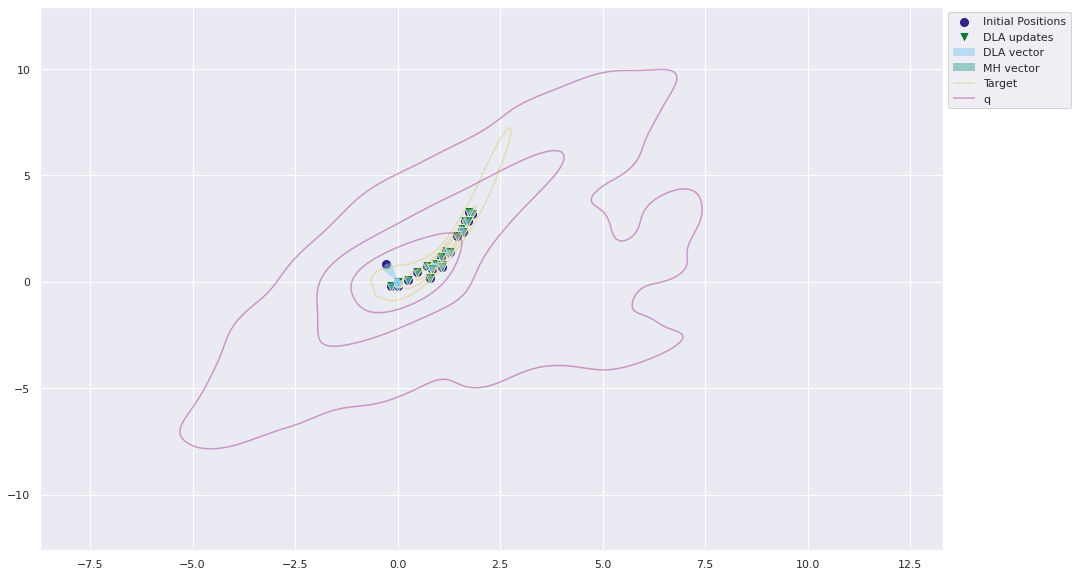

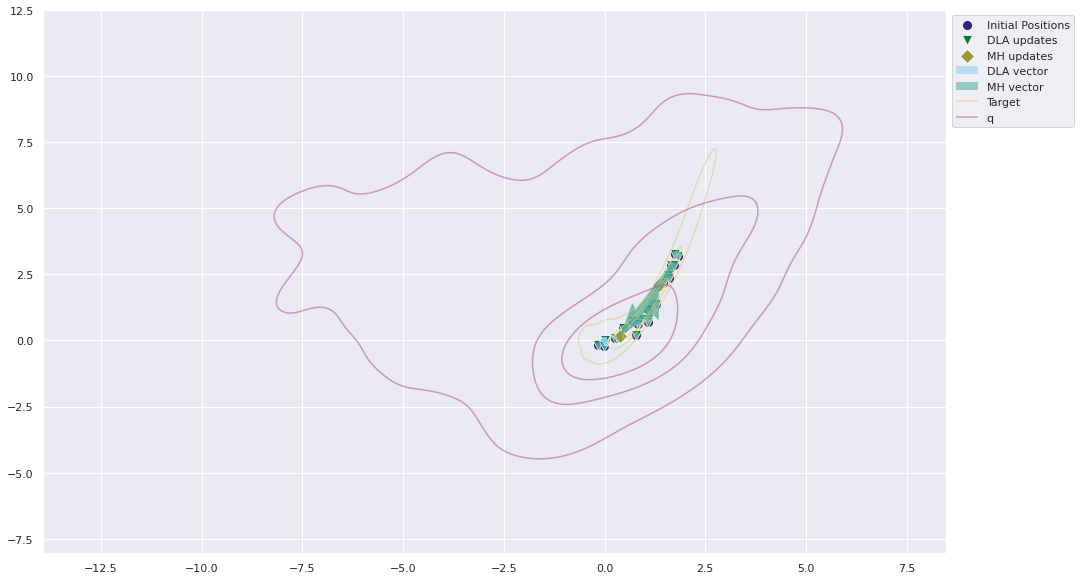

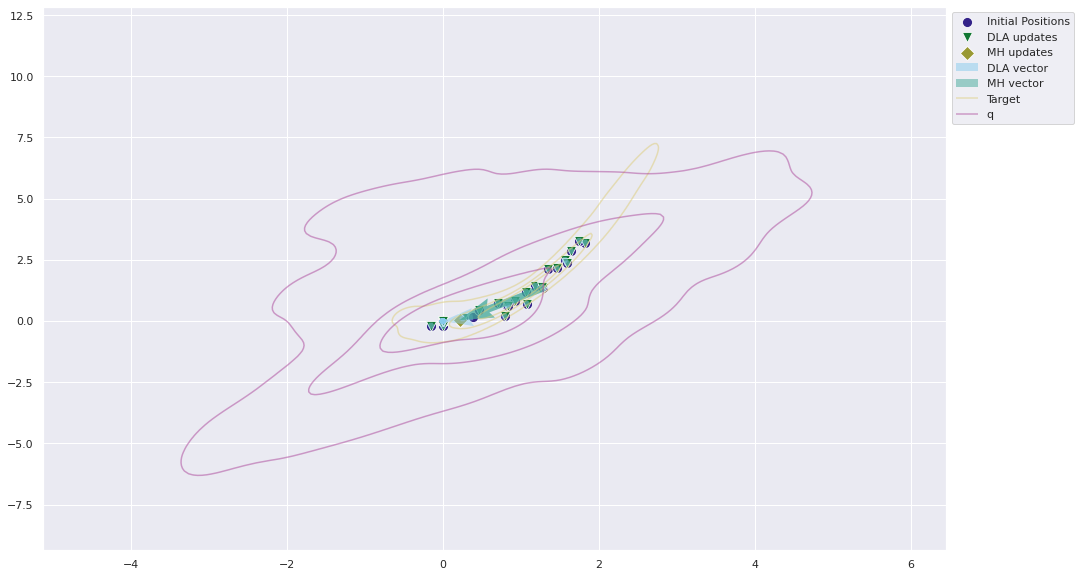

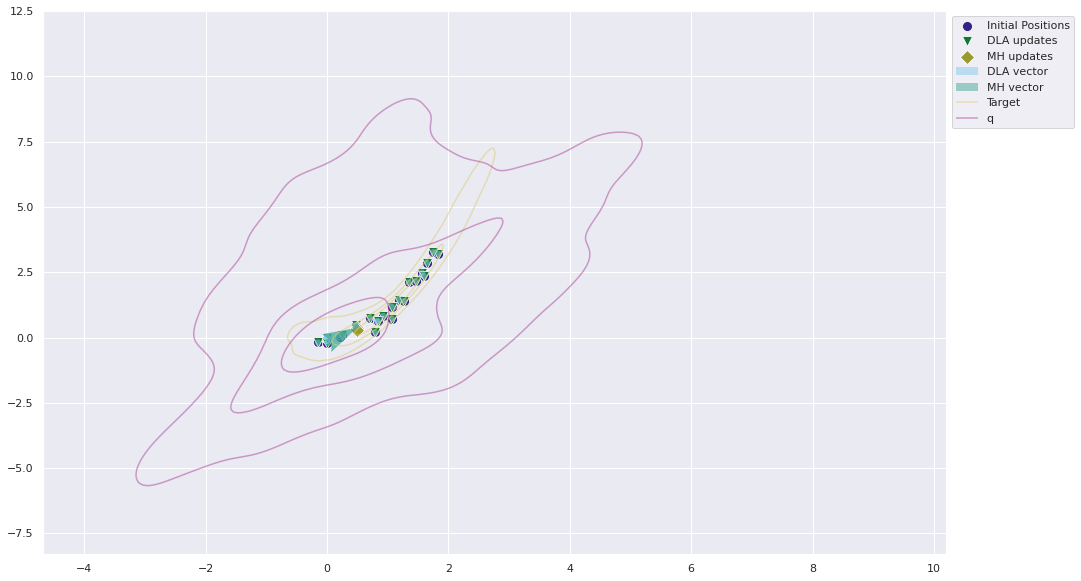

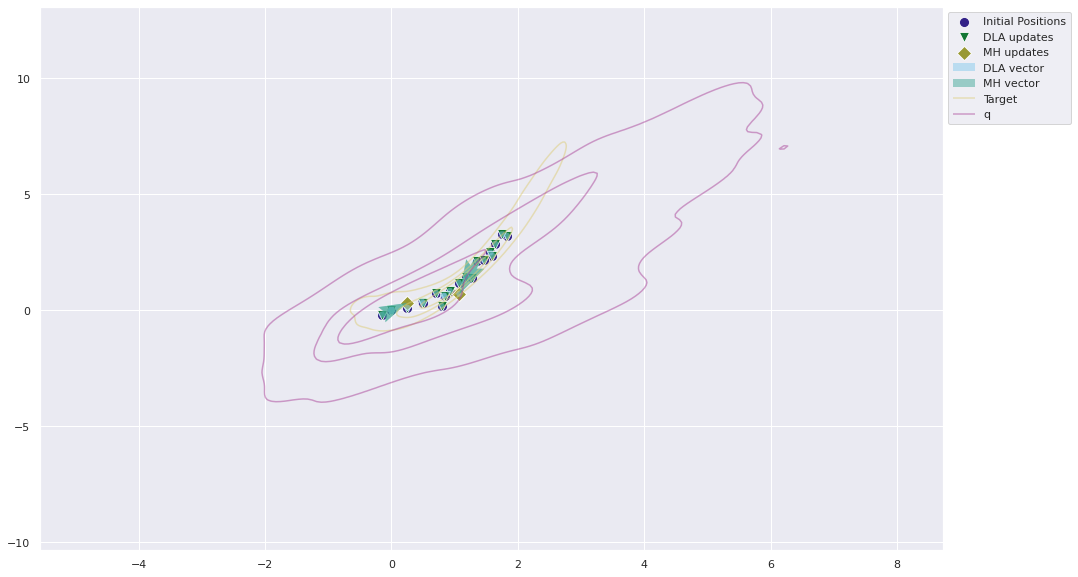

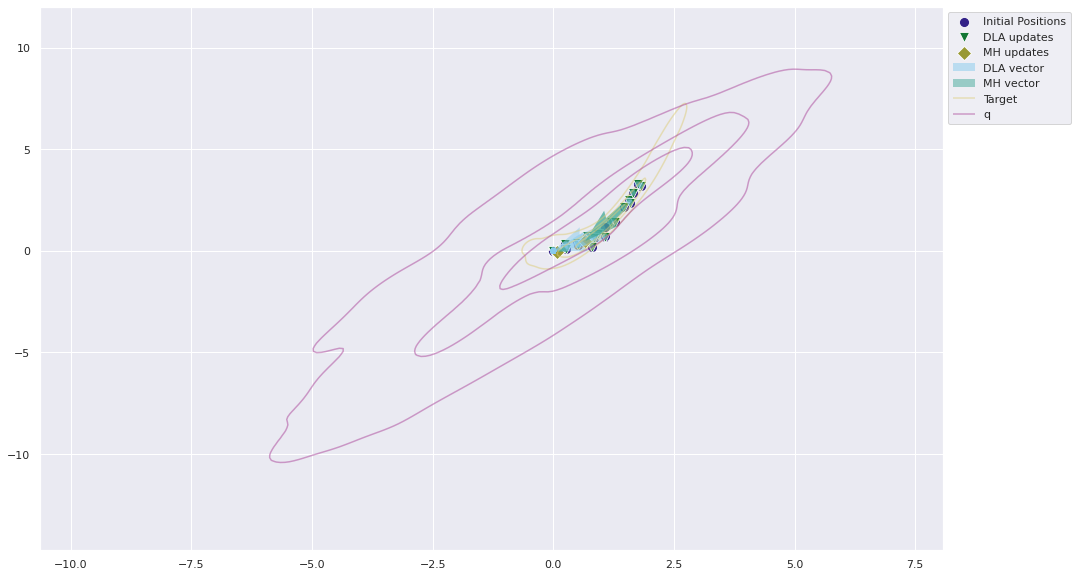

In [51]:
dla_samples = trace['dla_samples'][0]
mh_samples = trace['mh_samples'][0]
dla_keys = list(dla_samples.keys())



for i, key in enumerate(dla_keys):
    
    if key == 'post_burnin_0':
        continue
    
    if i == 0:
        print('init_key = prior')
        initial_samples = jax_prior_init
    elif i > 0:
        print(f'init_key = {dla_keys[i - 1]}')
        initial_samples = mh_samples[dla_keys[i - 1]]

    print(f'Current key = {key}')
    dla_updates = dla_samples[key]
    mh_updates = mh_samples[key]
    
    print(f'shape init = {np.shape(initial_samples)}')
    print(f'shape dla = {np.shape(dla_updates)}')
    print(f'shape mh = {np.shape(mh_updates)}')
    
    q = trace['dla_qmodels'][0][key]
    qx, _ = q.sample(2000, device='cpu')
    qx = qx.numpy()
    
    quiver_plot(initial_samples, dla_updates, mh_updates, truth_x[:,0:2], qx, markersize=100,
                levels=4, out_name=f'./dla_figs/banana_dla_iteration_{key}.png')